In [1]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import mne
import matplotlib.pyplot as plt
import pyvista
import ipywidgets
import ipyevents
import pyvistaqt
import yasa
import graphviz
import pydot
import pywt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_curve, auc
from sklearn.utils import class_weight

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

import scipy.signal as signal
from scipy.signal import hilbert
from scipy.signal import stft
from scipy.signal import butter, filtfilt
from scipy.signal import spectrogram

In [2]:
%matplotlib qt

## CNN model

### One-input model

In [63]:
def build_cnn_model_downsampled(input_shape=(300,1)):

    # linear embedding layer
    input_layer = tf.keras.layers.Input(shape=input_shape)

    # Three convolutional blocks (like having three pattern detectors)

    # First convolution block, kernel size of 5
    padded1 = tf.keras.layers.ZeroPadding1D(padding=2)(input_layer)
    conv1 = tf.keras.layers.Conv1D(filters=10, kernel_size=5, strides=1, padding='valid')(padded1)
    # each filter learns a different type of short-time feature
    # stride of 1, moves one step at a time
    conv1 = tf.keras.layers.LeakyReLU(alpha=0.01)(conv1)
    conv1 = tf.keras.layers.MaxPooling1D(pool_size=2)(conv1)
    # K = 2
    conv1 = tf.keras.layers.BatchNormalization()(conv1)

    # Second convolution block, kernel size of 11
    padded2 = tf.keras.layers.ZeroPadding1D(padding=5)(input_layer)
    conv2 = tf.keras.layers.Conv1D(filters=10, kernel_size=11, strides=1, padding='valid')(padded2)
    conv2 = tf.keras.layers.LeakyReLU(alpha=0.01)(conv2)
    conv2 = tf.keras.layers.MaxPooling1D(pool_size=2)(conv2)
    conv2 = tf.keras.layers.BatchNormalization()(conv2)

    # Third convolution block, kernel size of 21
    padded3 = tf.keras.layers.ZeroPadding1D(padding=10)(input_layer)
    conv3 = tf.keras.layers.Conv1D(filters=10, kernel_size=21, strides=1, padding='valid')(padded3)
    conv3 = tf.keras.layers.LeakyReLU(alpha=0.01)(conv3)
    conv3 = tf.keras.layers.MaxPooling1D(pool_size=2)(conv3)
    conv3 = tf.keras.layers.BatchNormalization()(conv3)

    # Concatenate the outputs of all blocks
    concatenated = tf.keras.layers.Concatenate()([conv1, conv2, conv3])

    # GRU Layer
    gru = tf.keras.layers.GRU(64)(concatenated)

    # Fully connected (dense) layer
    dense = tf.keras.layers.Dense(64, activation='relu')(gru)
    # add a Dropout layer to prevent overfitting
    #dense = tf.keras.layers.Dropout(0.5)(dense)

    # Two softmax outputs for dual-task classification
    #output_task1 = tf.keras.layers.Dense(2, activation='softmax', name='task1')(dense)
    #output_task2 = tf.keras.layers.Dense(2, activation='softmax', name='task2')(dense)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

    # Create the model
    #model = tf.keras.models.Model(inputs=input_layer, outputs=[output_task1, output_task2])
    model = tf.keras.models.Model(inputs=input_layer, outputs=output)

    # Compile the model
    #model.compile(optimizer='adam', loss={'task1': 'categorical_crossentropy', 'task2': 'categorical_crossentropy'}, metrics={'task1': 'accuracy', 'task2': 'accuracy'})
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    # Return the compiled model
    return model

### Two-input model

In [3]:
def build_multi_input_cnn_model_freq():
    # Inputs
    input_raw = tf.keras.Input(shape=(300, 1), name='raw_input')
    input_stft = tf.keras.Input(shape=(13, 1), name='stft_input')  

    def conv_branch(input_layer, kernel_sizes=[5, 11, 21]):
        outputs = []
        for k in kernel_sizes:
            pad = k // 2
            x = tf.keras.layers.ZeroPadding1D(padding=pad)(input_layer)
            x = tf.keras.layers.Conv1D(filters=10, kernel_size=k, strides=1, padding='valid')(x)
            x = tf.keras.layers.LeakyReLU(negative_slope=0.01)(x)
            x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
            x = tf.keras.layers.BatchNormalization()(x)
            outputs.append(x)
        return tf.keras.layers.Concatenate()(outputs)

    # Convolutional branches
    branch_raw = conv_branch(input_raw)
    branch_stft = conv_branch(input_stft)

    # Each branch through its own GRU
    gru_raw = tf.keras.layers.GRU(64)(branch_raw)
    gru_stft = tf.keras.layers.GRU(64)(branch_stft)

    # Concatenate GRU outputs (fixed-length vectors)
    merged = tf.keras.layers.Concatenate()([gru_raw, gru_stft])

    # Dense layers
    x = tf.keras.layers.Dense(64, activation='relu')(merged)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    # Build model
    model = tf.keras.Model(inputs=[input_raw, input_stft], outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

#### Model visualisations

In [15]:
def build_multi_input_cnn_model_freq_vis():
    # Inputs
    input_raw = tf.keras.Input(shape=(300, 1), name='raw_input')
    input_stft = tf.keras.Input(shape=(13, 1), name='stft_input')  

    def conv_branch(input_layer, kernel_sizes=[5, 11, 21], branch_name=""):
        outputs = []
        for k in kernel_sizes:
            pad = k // 2
            x = tf.keras.layers.ZeroPadding1D(
                padding=pad,
                name=f'{branch_name}_pad_k{k}'
            )(input_layer)
            x = tf.keras.layers.Conv1D(
                filters=10,
                kernel_size=k,
                strides=1,
                padding='valid',
                name=f'{branch_name}_conv_k{k}'
            )(x)
            x = tf.keras.layers.LeakyReLU(
                negative_slope=0.01,
                name=f'{branch_name}_leakyrelu_k{k}'
            )(x)
            x = tf.keras.layers.MaxPooling1D(
                pool_size=2,
                name=f'{branch_name}_pool_k{k}'
            )(x)
            x = tf.keras.layers.BatchNormalization(
                name=f'{branch_name}_bn_k{k}'
            )(x)
            outputs.append(x)
        return tf.keras.layers.Concatenate(name=f'{branch_name}_concat')(outputs)

    # Convolutional branches
    branch_raw = conv_branch(input_raw, branch_name="raw")
    branch_stft = conv_branch(input_stft, branch_name="stft")

    # GRU layers
    gru_raw = tf.keras.layers.GRU(64, name='gru_raw')(branch_raw)
    gru_stft = tf.keras.layers.GRU(64, name='gru_stft')(branch_stft)

    # Merge GRU outputs
    merged = tf.keras.layers.Concatenate(name='merge_gru_outputs')([gru_raw, gru_stft])

    # Dense layers
    x = tf.keras.layers.Dense(64, activation='relu', name='dense_relu')(merged)
    output = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(x)

    # Build model
    model = tf.keras.Model(inputs=[input_raw, input_stft], outputs=output, name='multi_input_cnn_freq')
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


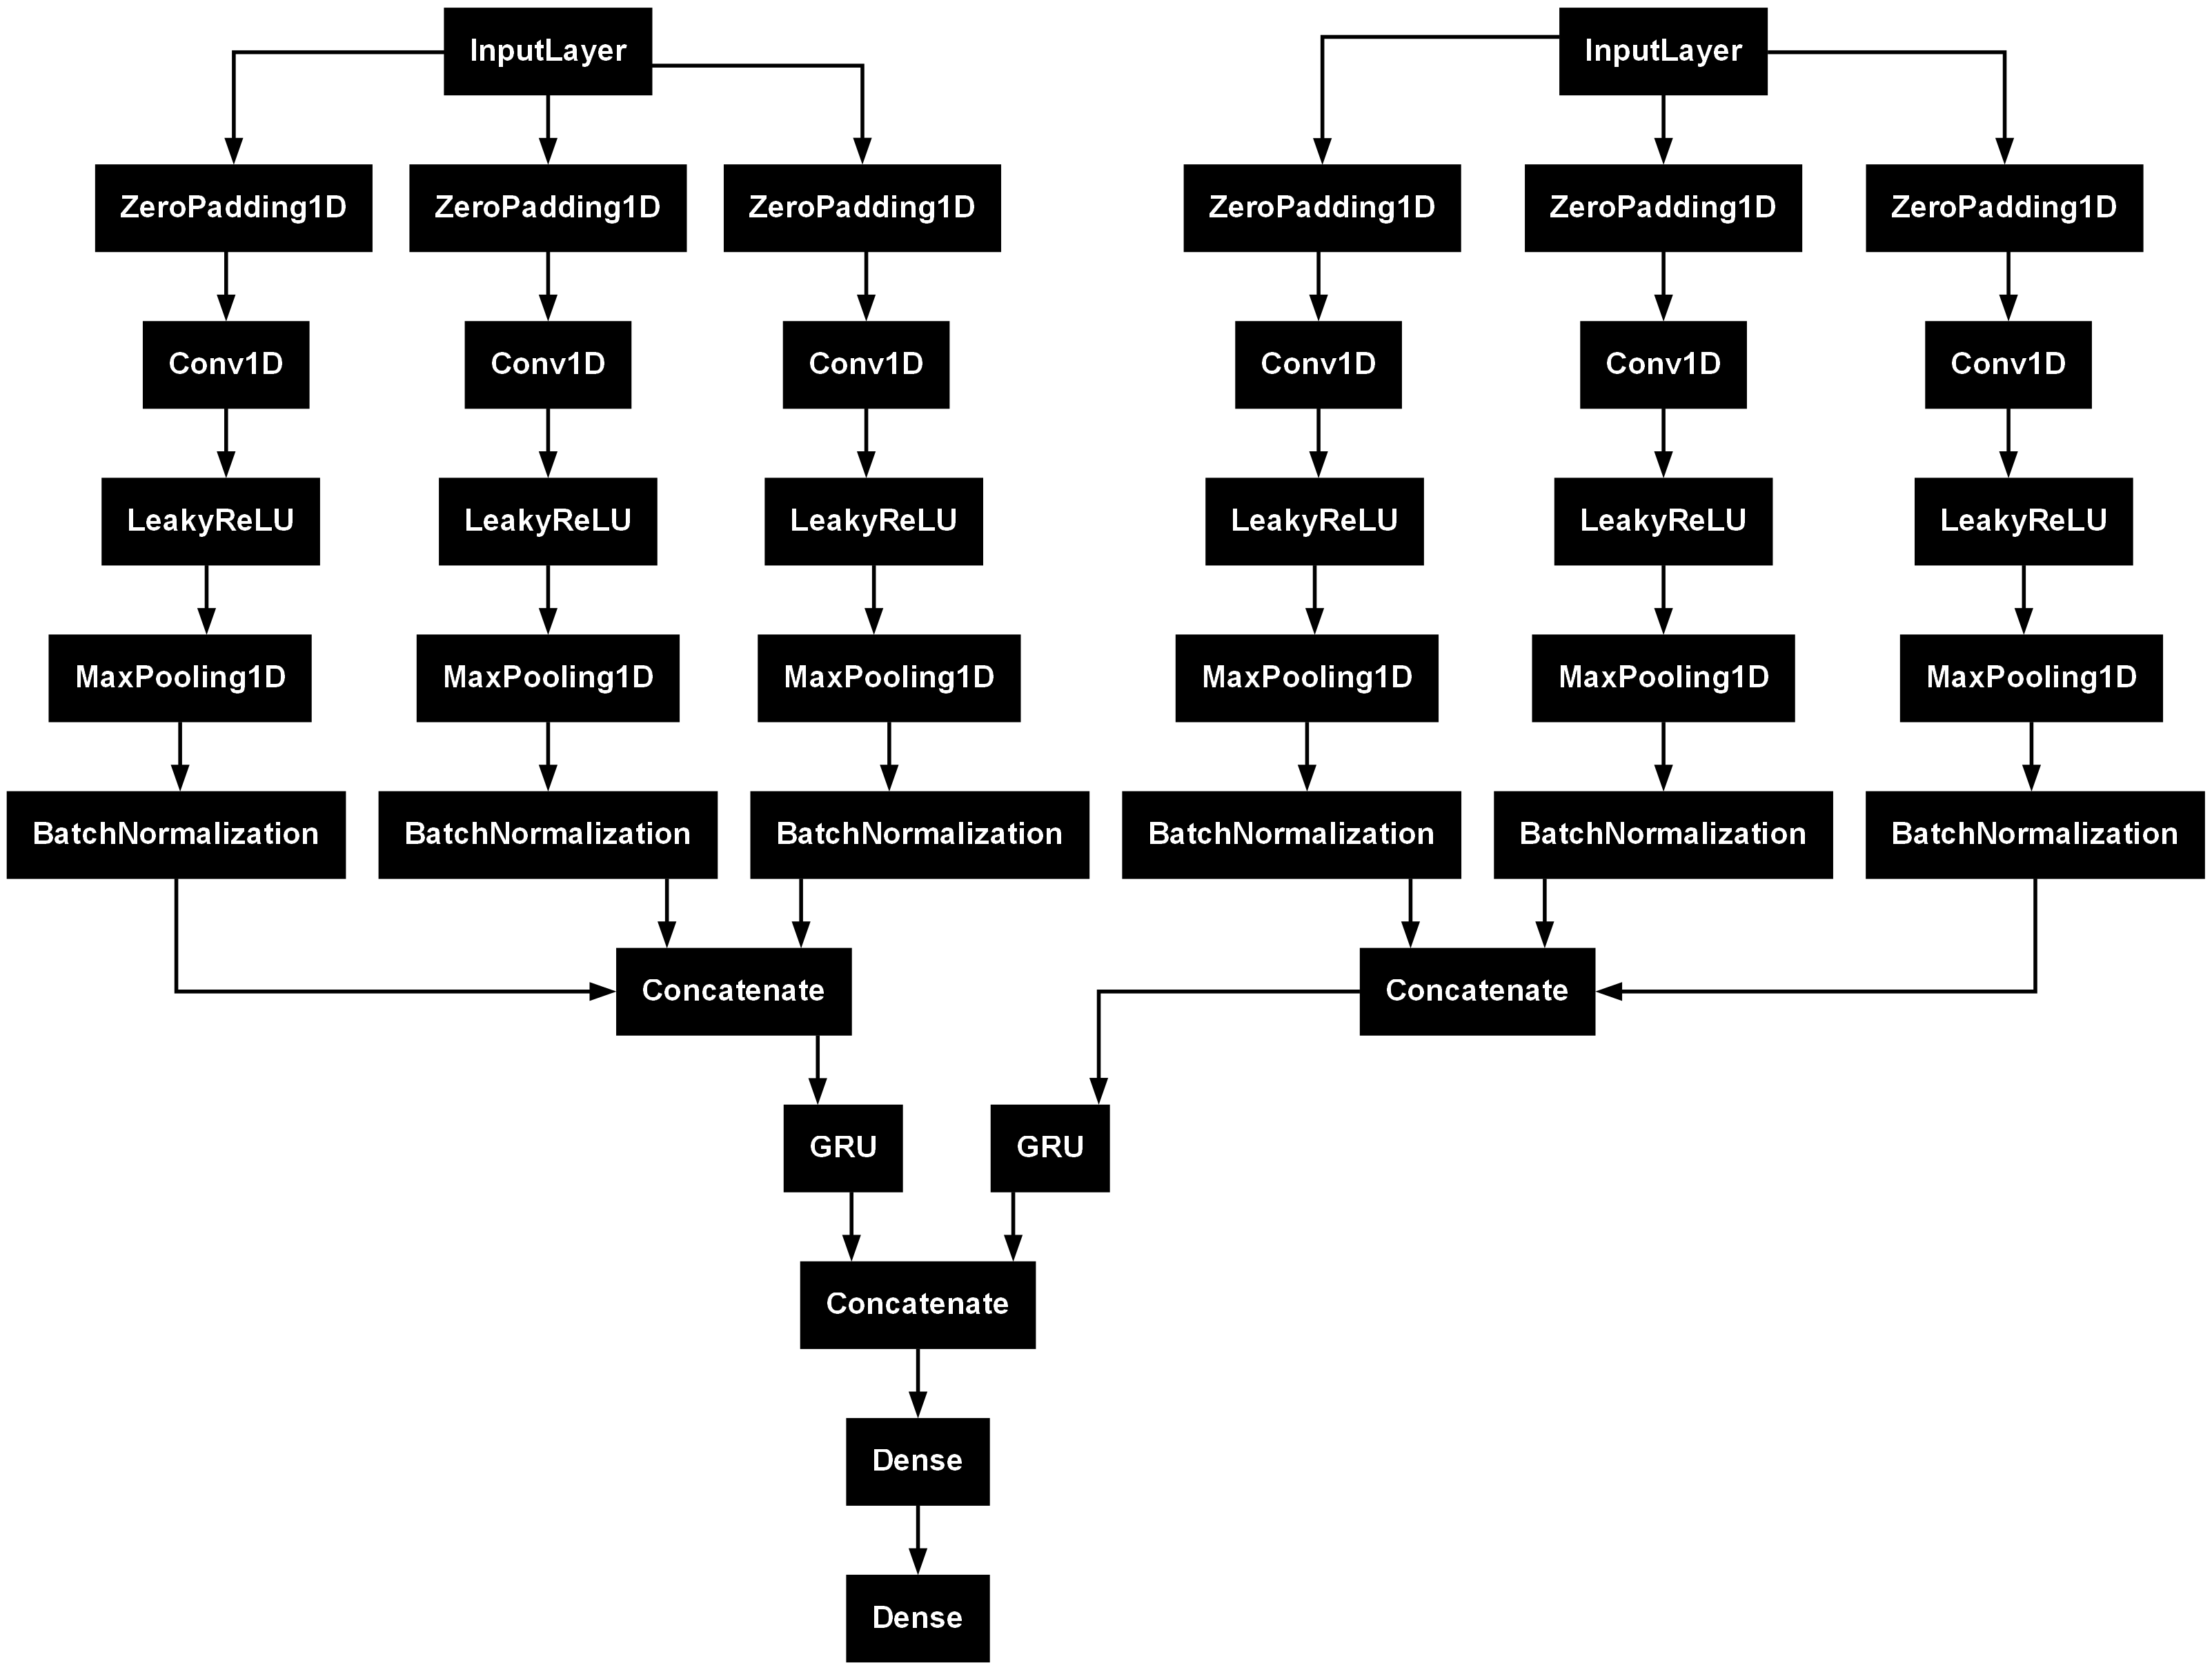

In [10]:
multi_input_cnn_model_freq = build_multi_input_cnn_model_freq()
plot_model(multi_input_cnn_model_freq, to_file='model_diagram.png', show_shapes=False, show_layer_names=False)

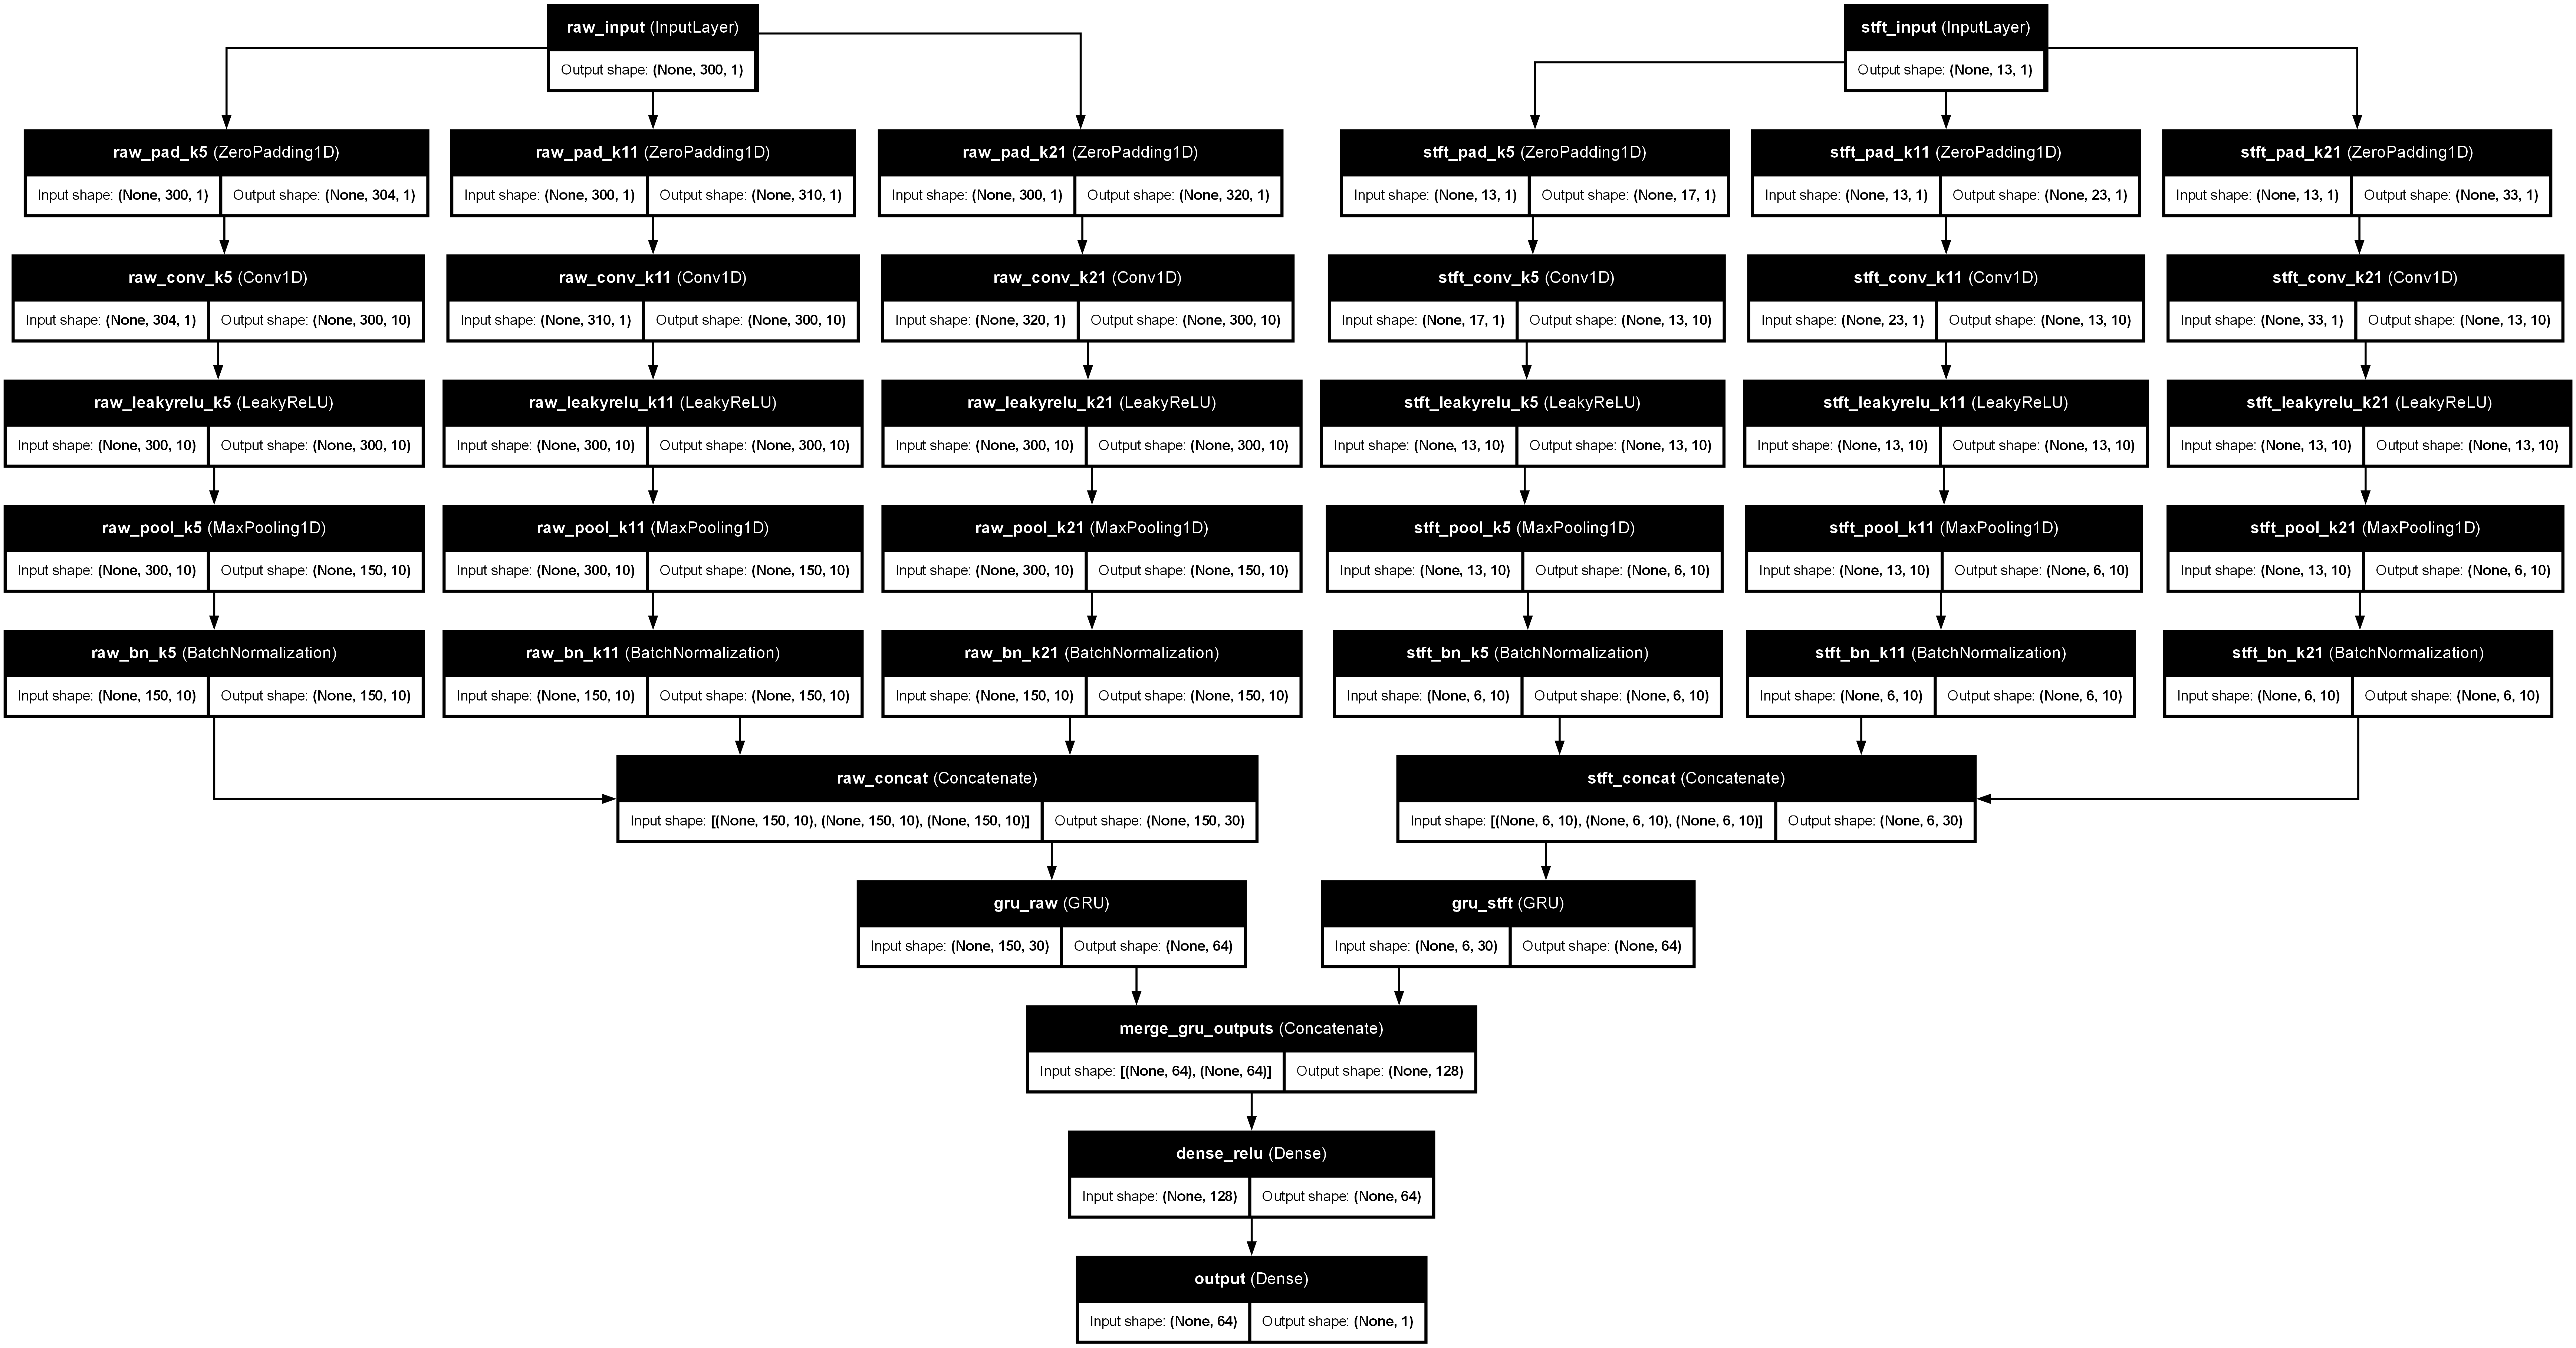

In [16]:
multi_input_cnn_model_freq_vis = build_multi_input_cnn_model_freq_vis()
plot_model(
    multi_input_cnn_model_freq_vis,
    to_file='model_diagram.png',
    show_shapes=True,
    show_layer_names=True,
)

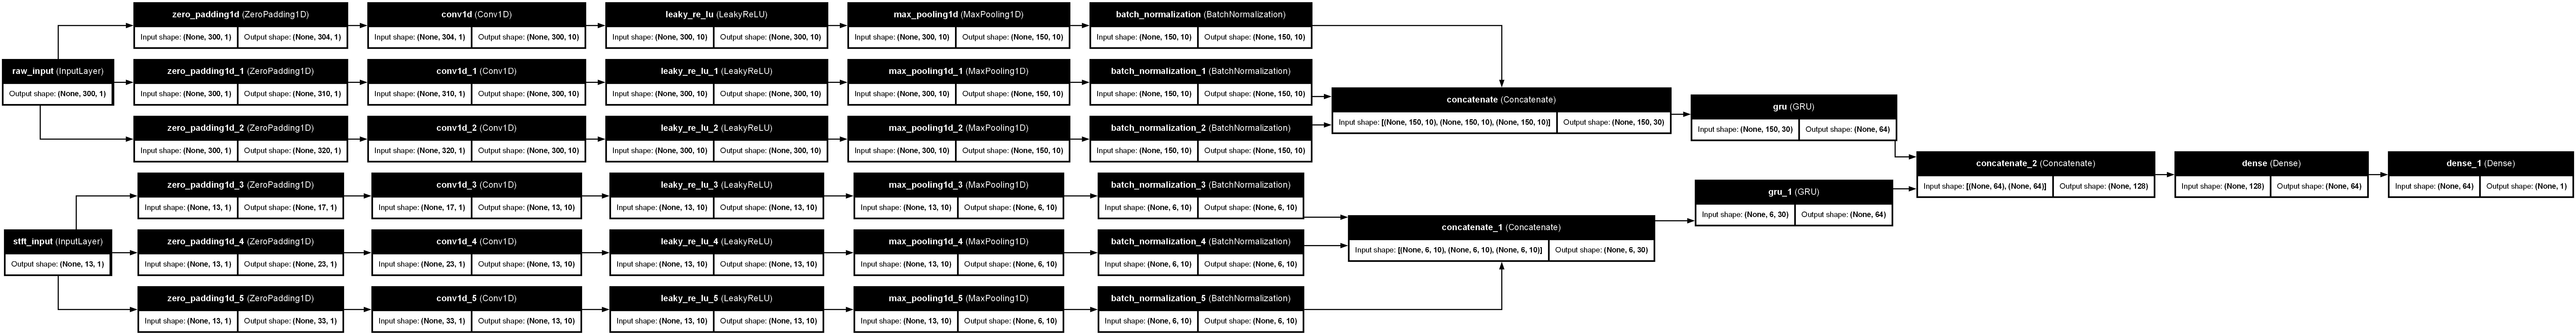

In [5]:
plot_model(
    multi_input_cnn_model_freq,
    to_file='model_diagram.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='LR',         # left-to-right layout
    dpi=150               # higher resolution
)

### Four-input model

In [4]:
def build_four_input_cnn_model_freq():
    # Inputs
    input_raw = tf.keras.Input(shape=(300, 1), name='raw_input')
    input_filtered_so = tf.keras.Input(shape=(300, 1), name='filtered_so')
    input_filtered_spindles = tf.keras.Input(shape=(300, 1), name='filtered_spindles')
    input_stft = tf.keras.Input(shape=(13, 1), name='stft_input')  

    def conv_branch(input_layer, kernel_sizes=[5, 11, 21]):
        outputs = []
        for k in kernel_sizes:
            pad = k // 2
            x = tf.keras.layers.ZeroPadding1D(padding=pad)(input_layer)
            x = tf.keras.layers.Conv1D(filters=10, kernel_size=k, strides=1, padding='valid')(x)
            x = tf.keras.layers.LeakyReLU(alpha=0.01)(x)
            x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
            x = tf.keras.layers.BatchNormalization()(x)
            outputs.append(x)
        return tf.keras.layers.Concatenate()(outputs)

    # Convolutional branches
    branch_raw = conv_branch(input_raw)
    branch_filtered_so = conv_branch(input_filtered_so)
    branch_filtered_spindles = conv_branch(input_filtered_spindles)
    branch_stft = conv_branch(input_stft)

    # Each branch through its own GRU
    gru_raw = tf.keras.layers.GRU(64)(branch_raw)
    gru_filtered_so = tf.keras.layers.GRU(64)(branch_filtered_so)
    gru_filtered_spindles = tf.keras.layers.GRU(64)(branch_filtered_spindles)
    gru_stft = tf.keras.layers.GRU(64)(branch_stft)

    # Concatenate GRU outputs (fixed-length vectors)
    merged = tf.keras.layers.Concatenate()([gru_raw, gru_filtered_so, gru_filtered_spindles, gru_stft])

    # Dense layers
    x = tf.keras.layers.Dense(64, activation='relu')(merged)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    # Build model
    model = tf.keras.Model(inputs=[input_raw, input_filtered_so, input_filtered_spindles, input_stft], outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

## Detection functions

### Slow oscillations

In [5]:
def detect_slow_oscillations_times(combined_raw, do_filter=True, do_downsample=False, downsample_rate=100):

    # according to methods from Klinzing et al.(2016)

    data = combined_raw.copy().pick_channels(['Fz'])

    if do_filter:
        data.filter(l_freq=0.16, h_freq=1.25)

    if do_downsample:
        data.resample(downsample_rate)
        
    sfreq = data.info['sfreq']
    channel_data = data.get_data()[0]
    
    # 3. find all positive-to-negative zero-crossings
    
    # zero_crossings = np.where( S!= 0)[0]
    # can also save this somewhere for further detection of spindles
    
    S = np.diff(np.sign(channel_data))
    # np.sign returns an array with 1 (positive), 0 (zero), -1 (negative)
    # np.diff calculates the difference between consecutive elements in an array
    # positive value: transition from negative to positive
    # negative value: transition from positive to negative
    # when it's a zero, means that value stayed the same
    zero_crossings = np.where(S < 0)[0]
    # -2 is when a positive-to-negative zero-crossing occurs
    # goes from 1 to -1 
    # -1 - 1 = -2
    # [0] extracts the actual array
    # extracts the indices of interest from current_data (not S)
    #signs = np.sign(current_data)
    #pos_to_neg = np.where((signs[:-1] > 0) & (signs[1:] < 0))[0]
    # detect +1 to -1
    #neg_to_pos = np.where((signs[:-1] <  0) & (signs[1:] > 0))[0]
    # detect -1 to +1

    # 4. Detect peak potentials in each pair
    slow_oscillations = []
    negative_peaks = []
    positive_peaks = []
    peak_to_peak_amplitudes = []
    candidate_indices = []

    # for loop for each pair
    # to collect all the negative and positive peaks
    # to further apply criteria
    count = 0
    for i in range(0, len(zero_crossings)-1, 1):
        # loop through all the zero_crossings
        # step of 1 (with step of 2, miss some zero_crossings)
        start_idx = zero_crossings[i] + 1
        # assigns index of zero-crossing (representing start of potential SO)
        # to start_idx
        end_idx = zero_crossings[i + 1] + 1
        # assigns index of next zero-crossing (representing end of potential SO)
        # to end_idx

        # find the negative to positive crossing in between
        #mid_crossings = neg_to_pos[(neg_to_pos > start_idx) & (neg_to_pos < end_idx)]

        #if len(mid_crossings) != 1:
            #continue

        #mid_idx = mid_crossings [0]

        #duration = (end_idx - start_idx) / sfreq
        #if not (0.8 <= duration <= 2.0):
  
        
        segment_length = (end_idx - start_idx) / sfreq

        # need to add +1 because of way extract segment later

        # have identified index for the pair
        
        # extract data segment between crossings
        
        # find peaks
        if 0.8 <= segment_length <= 2.0:
            count += 1
            segment = channel_data[start_idx:end_idx]
            positive_peak = np.max(segment)
            negative_peak = np.min(segment)
            peak_to_peak_amplitude = positive_peak - negative_peak

        # store values
            candidate_indices.append((start_idx, end_idx))
            positive_peaks.append(positive_peak)
            negative_peaks.append(negative_peak)
            peak_to_peak_amplitudes.append(peak_to_peak_amplitude)

    # calculate mean values for comparison
    #mean_negative_peak = np.mean(negative_peaks)
    # mean_negative_peak = np.mean(negative_peaks) if negative_peaks else 0
    #mean_peak_to_peak_amplitude = np.mean(peak_to_peak_amplitudes)
    # mean_peak_to_peak_amplitude = np.mean(peak_to_peak_amplitudes) if peak_to_peak_amplitudes else 0

    negative_peak_threshold = np.percentile(negative_peaks, 25)
    # keep lowest negative peaks (under the 25th percentile)
    peak_to_peak_amplitude_threshold = np.percentile(peak_to_peak_amplitudes, 75)
    # keep largest peak-to-peak amplitude (over 75th percentile)

    for (start_idx, end_idx), negative_peak, peak_to_peak_amplitude in zip(candidate_indices, negative_peaks, peak_to_peak_amplitudes):
        if peak_to_peak_amplitude >= peak_to_peak_amplitude_threshold and negative_peak <= negative_peak_threshold:
            slow_oscillations.append((start_idx / sfreq, end_idx / sfreq))
            
    return slow_oscillations
    # returns a list of tuples, in which each tuple represents the start and end times of
    # a detected slow oscillation

def detect_slow_oscillations_peaks(combined_raw, do_filter=True, do_downsample=True, downsample_rate=100):

    # according to methods from Klinzing et al.(2016)

    data = combined_raw.copy().pick_channels(['Fz'])

    if do_filter:
        data.filter(l_freq=0.16, h_freq=1.25)

    if do_downsample:
        data.resample(downsample_rate)
        
    sfreq = data.info['sfreq']
    channel_data = data.get_data()[0]
    
    # 3. find all positive-to-negative zero-crossings
    
    # zero_crossings = np.where( S!= 0)[0]
    # can also save this somewhere for further detection of spindles
    
    S = np.diff(np.sign(channel_data))
    # np.sign returns an array with 1 (positive), 0 (zero), -1 (negative)
    # np.diff calculates the difference between consecutive elements in an array
    # positive value: transition from negative to positive
    # negative value: transition from positive to negative
    # when it's a zero, means that value stayed the same
    zero_crossings = np.where(S < 0)[0]
    # -2 is when a positive-to-negative zero-crossing occurs
    # goes from 1 to -1 
    # -1 - 1 = -2
    # [0] extracts the actual array
    # extracts the indices of interest from current_data (not S)


    # 4. Detect peak potentials in each pair
    slow_oscillations = []
    slow_oscillations_peaks = []
    negative_peaks = []
    positive_peaks = []
    peak_to_peak_amplitudes = []
    candidate_indices =  []

    # for loop for each pair
    # to collect all the negative and positive peaks
    # to further apply criteria
    count = 0
    for i in range(0, len(zero_crossings) - 1, 1):
        # loop through all the zero_crossings
        # step of 1 (with step of 2, miss some zero_crossings)
        start_idx = zero_crossings[i] + 1
        # assigns index of zero-crossing (representing start of potential SO)
        # to start_idx
        end_idx = zero_crossings[i + 1] + 1
        # assigns index of next zero-crossing (representing end of potential SO)
        # to end_idx
        segment_length = (end_idx - start_idx) / sfreq

        # need to add +1 because of way extract segment later

        # have identified index for the pair
        
        # extract data segment between crossings
        
        # find peaks
        if 0.8 <= segment_length <= 2.0:
            count += 1
            segment = channel_data[start_idx:end_idx]
            positive_peak = np.max(segment)
            negative_peak = np.min(segment)
            peak_to_peak_amplitude = positive_peak - negative_peak

        # store values
            candidate_indices.append((start_idx, end_idx))
            positive_peaks.append(positive_peak)
            negative_peaks.append(negative_peak)
            peak_to_peak_amplitudes.append(peak_to_peak_amplitude)

    # calculate mean values for comparison
    #mean_negative_peak = np.mean(negative_peaks)
    # mean_negative_peak = np.mean(negative_peaks) if negative_peaks else 0
    #mean_peak_to_peak_amplitude = np.mean(peak_to_peak_amplitudes)
    # mean_peak_to_peak_amplitude = np.mean(peak_to_peak_amplitudes) if peak_to_peak_amplitudes else 0

    negative_peak_threshold = np.percentile(negative_peaks, 25)
    peak_to_peak_amplitude_threshold = np.percentile(peak_to_peak_amplitudes, 75)

    for (start_idx, end_idx), negative_peak, peak_to_peak_amplitude in zip(candidate_indices, negative_peaks, peak_to_peak_amplitudes):
        if peak_to_peak_amplitude >= peak_to_peak_amplitude_threshold and negative_peak <= negative_peak_threshold:
            slow_oscillations.append((start_idx / sfreq, end_idx / sfreq))
            slow_oscillations_peaks.append((negative_peak, positive_peak))

            
    return slow_oscillations
    # returns a list of tuples, in which each tuple represents the start and end times of
    # a detected slow oscillation

In [6]:
def detect_spindles_times(eeg_raw, do_filter=True, do_downsample=False, downsample_rate=100):
    
    # 1. Filter between 12 and 16 Hz
    
    data = eeg_raw.copy().pick_channels(['Fz'])

    if do_filter:
        data.filter(l_freq=12, h_freq=16)
    
    # 2. Downsample at 100 Hz (100 samples per second)

    if do_downsample:
        data.resample(downsample_rate)
    
    sfreq = data.info['sfreq']  
    channel_data = data.get_data()[0]
    # extract the filtered data
    
    
    # 3: Calculate amplitude by applying Hilbert transformation

    hilbert_signal = hilbert(channel_data)
    # apply hilbert transformation to bandpassed data
    # gives analytic signal with amplitude and phase information
    envelope = np.abs(hilbert_signal)
    # take the absolute part of the hilbert signal
    # also the instantaneous power of the signal
    # gives the envelope: amplitude modulation
    # how strength of oscillations change over time
    # size of sliding window
    
    # 4: Perform smoothing with a sliding window of 0.2 seconds
    # this removes high-frequency noise
    
    sliding_window = int(0.2 * sfreq)
    smoothed_envelope = np.convolve(envelope, np.ones(sliding_window) / sliding_window, mode='same')
    # convolving envelope with a uniform filter over the sliding window
    # convolution takes rolling average of 20 samples at a time
    # smooth the signal with the average of values in the window
    # in the smoothed envelope, can detect regions with higher amplitude 
    # which is when a spindle event occurs
    # np.ones: creates a filter kernel
    # have a filter where the sum of all elements equals 1
    # this filter is replaced by the average of the 20 surrounding samples
    # convolution between envelope and averaging filter
    # mode = 'same': so that output of convolution has same length as original envelope

    # 5. Define spindle detection threshold

    threshold = np.percentile(smoothed_envelope, 75)
    spindle_threshold = smoothed_envelope > threshold
    #threshold = np.mean(smoothed_envelope) + 1.5 * np.std(smoothed_envelope)
    #spindle_threshold = smoothed_envelope > threshold
    # threshold is 75th percentile of the smoothed envelope
    # will look at the duration later
    
    # 6. Detect spindles and define peaks and troughs for visualisation
    
    spindles = []
    # initialize list with spindles
    above_threshold = np.where(spindle_threshold)[0]
    # returns indices where signal above the threshold
    stacked_spindles = []
    # initialize list for stacking the spindles for the visualisation
    # contains aligned spindles at peak
    
    if len(above_threshold) > 0:
        # checking it's not empty
        start_idx = above_threshold[0]
        # would be the start of a potential spindle
        for i in range(1, len(above_threshold)):
            if above_threshold[i] > above_threshold[i - 1] + 1:  
                # if above threshold[1] > above_threshold[0] + 1
                # because all indices should be separated by 1
                # so here detects gaps
                # so starting from the second index
                # and comparing each index to the one before
                end_idx = above_threshold[i - 1]
                # so if above condition is true, this is the end of the spindle
                duration = (end_idx - start_idx) / sfreq
                if 0.5 <= duration <= 3:
                    # only keep spindles lasting 0.5 to 3 seconds
                    segment = channel_data[start_idx:end_idx]
                    # extract EEG segment corresponding to detected spindle
                    peak_idx = start_idx + np.argmax(segment) 
                    # extract the peak of the spindle
                    # this will be useful for later
                    spindles.append((start_idx / sfreq, end_idx / sfreq))
                    # all the spindles are stored in spindles
                    
                    # Aligning spindles at peak for visualization
                    before_peak_idx = max(0, peak_idx - int(1.5 * sfreq))
                    # still in the for loop, so this is the peak index of individual peak
                    after_peak_idx = min(len(channel_data), peak_idx + int(1.5 * sfreq))
                    # extracting 1.5 seconds before and after peak
                    # max and min are used for out of bounds situations at the start and end of EEG data
                    aligned_segment = channel_data[before_peak_idx:after_peak_idx]
                    stacked_spindles.append(aligned_segment)
                    # the aligned segment is saved in stacked spindles
                
                start_idx = above_threshold[i]
                # update the start index for the for loop

        # then need to process the final spindle
        end_idx = above_threshold[-1]
        duration = (end_idx - start_idx) / sfreq
        if 0.5 <= duration <= 3:
            segment = channel_data[start_idx:end_idx]
            peak_idx = start_idx + np.argmax(segment)
            spindles.append((start_idx / sfreq, end_idx / sfreq))

            before_peak_idx = max(0, peak_idx - int(1.5 * sfreq))
            after_peak_idx = min(len(channel_data), peak_idx + int(1.5 * sfreq))
            aligned_segment = channel_data[before_peak_idx:after_peak_idx]
            stacked_spindles.append(aligned_segment)
    
    return spindles
    

def detect_spindles_peaks(eeg_raw, do_filter=True, do_downsample=False, downsample_rate=100):
    
    # 1. Filter between 12 and 16 Hz
    
    data = eeg_raw.copy().pick_channels(['Fz'])

    if do_filter:
        data.filter(l_freq=12, h_freq=16)
    
    # 2. Downsample at 100 Hz (100 samples per second)
    
    if do_downsample:
        data.resample(downsample_rate)
        
    sfreq = data.info['sfreq']  
    # update to new sampling frequency
    # because used later in the code
    channel_data = data.get_data()[0]
    # extract the filtered data
    
    # 3: Calculate amplitude by applying Hilbert transformation

    hilbert_signal = hilbert(channel_data)
    # apply hilbert transformation to bandpassed data
    # gives analytic signal with amplitude and phase information
    envelope = np.abs(hilbert_signal)
    # take the absolute part of the hilbert signal
    # also the instantaneous power of the signal
    # gives the envelope: amplitude modulation
    # how strength of oscillations change over time
    # size of sliding window
    
    # 4: Perform smoothing with a sliding window of 0.2 seconds
    # this removes high-frequency noise
    
    sliding_window = int(0.2 * sfreq)
    smoothed_envelope = np.convolve(envelope, np.ones(sliding_window) / sliding_window, mode='same')
    # convolving envelope with a uniform filter over the sliding window
    # convolution takes rolling average of 20 samples at a time
    # smooth the signal with the average of values in the window
    # in the smoothed envelope, can detect regions with higher amplitude 
    # which is when a spindle event occurs
    # np.ones: creates a filter kernel
    # have a filter where the sum of all elements equals 1
    # this filter is replaced by the average of the 20 surrounding samples
    # convolution between envelope and averaging filter
    # mode = 'same': so that output of convolution has same length as original envelope

    # 5. Define spindle detection threshold

    threshold = np.percentile(smoothed_envelope, 75)
    spindle_threshold = smoothed_envelope > threshold
    # 75th percentile as criteria

    #threshold = np.mean(smoothed_envelope) + 1.5 * np.std(smoothed_envelope)
    #spindle_threshold = smoothed_envelope > threshold
    
    # 6. Detect spindles and define peaks and troughs for visualisation
    
    spindles = []
    # initialize list with spindles
    above_threshold = np.where(spindle_threshold)[0]
    # returns indices where signal above the threshold
    stacked_spindles = []
    # initialize list for stacking the spindles for the visualisation
    # contains aligned spindles at peak
    
    if len(above_threshold) > 0:
        # checking it's not empty
        start_idx = above_threshold[0]
        # would be the start of a potential spindle
        for i in range(1, len(above_threshold)):
            if above_threshold[i] > above_threshold[i - 1] + 1:  
                # if above threshold[1] > above_threshold[0] + 1
                # because all indices should be separated by 1
                # so here detects gaps
                end_idx = above_threshold[i - 1]
                # so if above condition is true, this is the end of the spindle
                duration = (end_idx - start_idx) / sfreq
                if 0.5 <= duration <= 3:
                    # only keep spindles lasting 0.5 to 3 seconds
                    segment = channel_data[start_idx:end_idx]
                    # extract EEG segment corresponding to detected spindle
                    peak_idx = start_idx + np.argmax(segment) 
                    # extract the peak of the spindle
                    # this will be useful for later
                    #spindles.append(f"Spindle detected from {start_idx / sfreq:.2f}s to {end_idx / sfreq:.2f}s, peak at {peak_idx / sfreq:.2f}s")
                    spindles.append((peak_idx / sfreq))
                    # all the spindles are stored in spindles
                    
                    # Aligning spindles at peak for visualization
                    before_peak_idx = max(0, peak_idx - int(1.5 * sfreq))
                    # still in the for loop, so this is the peak index of individual peak
                    after_peak_idx = min(len(channel_data), peak_idx + int(1.5 * sfreq))
                    # extracting 1.5 seconds before and after peak
                    # max and min are used for out of bounds situations at the start and end of EEG data
                    aligned_segment = channel_data[before_peak_idx:after_peak_idx]
                    stacked_spindles.append(aligned_segment)
                    # the aligned segment is saved in stacked spindles
                
                start_idx = above_threshold[i]
                # update the start index for the for loop

        # then need to process the final spindle
        end_idx = above_threshold[-1]
        duration = (end_idx - start_idx) / sfreq
        if 0.5 <= duration <= 3:
            segment = channel_data[start_idx:end_idx]
            peak_idx = start_idx + np.argmax(segment)
            spindles.append((peak_idx / sfreq))

            before_peak_idx = max(0, peak_idx - int(1.5 * sfreq))
            after_peak_idx = min(len(channel_data), peak_idx + int(1.5 * sfreq))
            aligned_segment = channel_data[before_peak_idx:after_peak_idx]
            stacked_spindles.append(aligned_segment)

    
    return spindles

In [7]:
def detect_slow_oscillations_spindles_coupling_so_times(combined_raw, do_filter=True, do_downsample=True, downsample_rate=100):
    slow_oscillations_peaks = detect_slow_oscillations_peaks(combined_raw, do_filter=do_filter, do_downsample=do_downsample, downsample_rate=downsample_rate)
    slow_oscillations_times = detect_slow_oscillations_times(combined_raw, do_filter=do_filter, do_downsample=do_downsample, downsample_rate=downsample_rate)
    spindles_peaks = detect_spindles_peaks(combined_raw, do_filter=do_filter, do_downsample=do_downsample, downsample_rate=downsample_rate)

    coupling_times = []
    coupling_times_so = []

    # first detect the coupling events
    for (start_time, end_time), (negative_peak, positive_peak) in zip(slow_oscillations_times, slow_oscillations_peaks):
        for peak in spindles_peaks:
            if negative_peak < peak < end_time:
                coupling_times.append(peak)
                # if the peak of the spindle is between the negative and positive trough
                # add it to list of coupling times

    # then calculate the slow oscillation length
    for start_time, end_time in slow_oscillations_times:
        current_start_time = start_time
        current_end_time = end_time
        for coupling_peak in coupling_times:
            if current_start_time < coupling_peak < current_end_time:
                coupling_times_so.append((current_start_time, current_end_time))

    return coupling_times_so

## Epochs function

In [8]:
def create_fixed_length_epochs(raw, duration=3.0, overlap=0.0, preload=True, reject_by_annotation=False):

    return mne.make_fixed_length_epochs(
        raw,
        duration=duration,
        overlap=overlap,
        preload=preload,
        reject_by_annotation=reject_by_annotation
    )
# function mne.make_fixed_length_epochs takes into account the sampling frequency of the data

def label_coupling_epochs(epochs, coupling_starts, coupling_ends, epoch_length_sec=3.0):

    epoch_starts = np.arange(len(epochs)) * epoch_length_sec
    # new np array with the start time of each epoch
    # epoch_starts[i] is the start time of each epoch

    epoch_labels = np.zeros(len(epochs), dtype=int)
    # initialize all the labels as 0 initially

    for start, end in zip(coupling_starts, coupling_ends):
        # loop through the start and end times of detected spindles by YASA
        for i, epoch_start in enumerate(epoch_starts):
            # loop through the one-second epochs that are not labelled yet
            epoch_end = epoch_start + epoch_length_sec
            # for each epoch, calculate the epoch end time
            # which is epoch_start + length of epoch
            # so now have the time range of each epoch
            if (start < epoch_end) and (end > epoch_start):
                # if the spindle started before the epoch ends
                # and the spindle ended after the epoch started
                epoch_labels[i] = 1
                
    return epoch_labels

def label_coupling_epochs_moderate(epochs, coupling_starts, coupling_ends, epoch_length_sec=3.0):
    epoch_starts = np.arange(len(epochs)) * epoch_length_sec
    epoch_labels = np.zeros(len(epochs), dtype=int)

    for coupling_start, coupling_end in zip(coupling_starts, coupling_ends):
        coupling_duration = coupling_end - coupling_start
        required_overlap = 0.5 * coupling_duration  
        # only label 1 if epoch contains 50% of the SO duration

        for i, epoch_start in enumerate(epoch_starts):
            epoch_end = epoch_start + epoch_length_sec

            # Calculate overlap between coupling and epoch
            overlap_start = max(coupling_start, epoch_start)
            overlap_end = min(coupling_end, epoch_end)
            overlap_duration = overlap_end - overlap_start

            if overlap_duration >= required_overlap:
                epoch_labels[i] = 1

    return epoch_labels

## Data augmentation function

In [23]:
def augment_coupling_epochs_with_jitter_and_noise(epochs, labels, sfreq, 
                                             blank_duration=0.3,
                                             jitter_max_shift_sec=0.2, 
                                             noise_std=0.01,
                                             n_augments_per_coupling=2):


    blank_samples = int(blank_duration * sfreq)
    jitter_max_shift = int(jitter_max_shift_sec * sfreq)
    n_samples, n_channels = epochs.shape[1], epochs.shape[2]

    augmented_epochs = []
    augmented_labels = []

    for epoch, label in zip(epochs, labels):
        # Keep the original epoch
        augmented_epochs.append(epoch)
        augmented_labels.append(label)

        if label == 1:
            # Create zero-padding for jittering
            blank = np.zeros((blank_samples, n_channels))
            padded = np.concatenate([blank, epoch, blank], axis=0)

            for _ in range(n_augments_per_coupling):
                # Random jitter
                shift = np.random.randint(-jitter_max_shift, jitter_max_shift + 1)
                jittered = np.roll(padded, shift=shift, axis=0)

                # Add Gaussian noise
                noise = np.random.normal(0, noise_std, size=jittered.shape)
                jittered_noisy = jittered + noise

                # Remove padding: trim to original size
                augmented = jittered_noisy[blank_samples : blank_samples + n_samples]

                augmented_epochs.append(augmented)
                augmented_labels.append(1)

    return np.array(augmented_epochs), np.array(augmented_labels)


## Importing data

In [10]:
# file paths
train_file = r"C:\EEG DATA\combined_sets\train_raw.fif"
test_file = r"C:\EEG DATA\combined_sets\test_raw.fif"

# load raw files
train_raw = mne.io.read_raw_fif(train_file, preload=True)
test_raw = mne.io.read_raw_fif(test_file, preload=True)

Opening raw data file C:\EEG DATA\combined_sets\train_raw.fif...
Isotrak not found
    Range : 1470000 ... 23295072 =   2940.000 ... 46590.144 secs
Ready.
Reading 0 ... 21825072  =      0.000 ... 43650.144 secs...
Opening raw data file C:\EEG DATA\combined_sets\test_raw.fif...
Isotrak not found
    Range : 825000 ... 17985049 =   1650.000 ... 35970.098 secs
Ready.
Reading 0 ... 17160049  =      0.000 ... 34320.098 secs...


## With raw data

### Coupling detection

In [11]:
coupling_train_times_raw_downsampled = detect_slow_oscillations_spindles_coupling_so_times(train_raw, do_filter=True, do_downsample=True)
coupling_test_times_raw_downsampled = detect_slow_oscillations_spindles_coupling_so_times(test_raw, do_filter=True, do_downsample=True)

coupling_starts_train_raw_downsampled, coupling_ends_train_raw_downsampled = zip(*coupling_train_times_raw_downsampled) if coupling_train_times_raw_downsampled else([],[])
coupling_starts_test_raw_downsampled, coupling_ends_test_raw_downsampled = zip(*coupling_test_times_raw_downsampled) if coupling_test_times_raw_downsampled else([],[])

print(len(coupling_starts_train_raw_downsampled))
print(len(coupling_ends_train_raw_downsampled))

print(len(coupling_starts_test_raw_downsampled))
print(len(coupling_ends_test_raw_downsampled))

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 73 contiguous segments
Setting up band-pass filter from 0.16 - 1.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.16
- Lower transition bandwidth: 0.16 Hz (-6 dB cutoff frequency: 0.08 Hz)
- Upper passband edge: 1.25 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.25 Hz)
- Filter length: 10313 samples (20.626 s)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 73 contiguous segments
Setting up band-pass filter from 0.16 - 1.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194

### Downsample

In [12]:
train_raw_downsampled = train_raw.copy().resample(100)
test_raw_downsampled = test_raw.copy().resample(100)

print(train_raw_downsampled.info['sfreq'])
print(test_raw_downsampled.info['sfreq'])

100.0
100.0


### Epoch the data

In [13]:
epochs_train_raw_downsampled = create_fixed_length_epochs(train_raw_downsampled)
epochs_test_raw_downsampled = create_fixed_length_epochs(test_raw_downsampled)
print(epochs_train_raw_downsampled.get_data().shape)
print(epochs_test_raw_downsampled.get_data().shape)

Not setting metadata
14550 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 14550 events and 300 original time points ...
0 bad epochs dropped
Not setting metadata
11440 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11440 events and 300 original time points ...
0 bad epochs dropped
(14550, 1, 300)
(11440, 1, 300)


#### 50% threshold (moderate)

In [14]:
%%time

# Train set

epoch_labels_train_raw_downsampled_moderate = label_coupling_epochs_moderate(epochs_train_raw_downsampled, coupling_starts_train_raw_downsampled, coupling_ends_train_raw_downsampled)

print(f"Train data first 60 coupling events: {coupling_starts_train_raw_downsampled[:60]}")
print(f"Train labels first 60 epochs: {epoch_labels_train_raw_downsampled_moderate[:60]}")

# Test set

epoch_labels_test_raw_downsampled_moderate = label_coupling_epochs_moderate(epochs_test_raw_downsampled, coupling_starts_test_raw_downsampled, coupling_ends_test_raw_downsampled)

print(f"\nTest data first 60 coupling events: {coupling_starts_test_raw_downsampled[:60]}")
print(f"Test labels first 60 epochs: {epoch_labels_test_raw_downsampled_moderate[:60]}")

Train data first 60 coupling events: (np.float64(83.41), np.float64(108.08), np.float64(262.01), np.float64(274.78), np.float64(378.52), np.float64(482.73), np.float64(502.23), np.float64(567.15), np.float64(599.39), np.float64(600.94), np.float64(685.84), np.float64(697.85), np.float64(707.43), np.float64(708.93), np.float64(720.49), np.float64(732.11), np.float64(776.09), np.float64(780.06), np.float64(864.6), np.float64(871.32), np.float64(910.43), np.float64(917.07), np.float64(960.41), np.float64(1050.52), np.float64(1200.05), np.float64(1262.04), np.float64(1278.35), np.float64(1330.87), np.float64(1356.47), np.float64(1371.44), np.float64(1395.83), np.float64(1449.16), np.float64(1566.73), np.float64(1615.49), np.float64(1616.67), np.float64(1973.78), np.float64(2039.95), np.float64(2091.33), np.float64(2121.41), np.float64(2244.99), np.float64(2244.99), np.float64(2367.83), np.float64(2368.8), np.float64(2440.8), np.float64(2445.04), np.float64(2565.68), np.float64(2910.09), np

In [15]:
print("With 50% threshold:")
# Train set
train_labels = epoch_labels_train_raw_downsampled_moderate
train_counts = np.bincount(train_labels)
train_total = len(train_labels)

print("\nTrain label distribution:")
for label, count in enumerate(train_counts):
    proportion = count / train_total
    print(f"Label {label}: count = {count}, proportion = {proportion:.2%}")

# Test set
test_labels = epoch_labels_test_raw_downsampled_moderate
test_counts = np.bincount(test_labels)
test_total = len(test_labels)

print("\nTest label distribution:")
for label, count in enumerate(test_counts):
    proportion = count / test_total
    print(f"Label {label}: count = {count}, proportion = {proportion:.2%}")

With 50% threshold:

Train label distribution:
Label 0: count = 13463, proportion = 92.53%
Label 1: count = 1087, proportion = 7.47%

Test label distribution:
Label 0: count = 10605, proportion = 92.70%
Label 1: count = 835, proportion = 7.30%


### Data augmentation

In [16]:
# Reshape arrays

epochs_train_np_raw_downsampled = np.array(epochs_train_raw_downsampled).reshape(len(epochs_train_raw_downsampled), -1, 1)
# number of epochs N, sampling frequency (time dimension automatically inferred), channel dimension
#epochs_test_np_raw_downsampled = np.array(epochs_test_raw_downsampled).reshape(len(epochs_test_raw_downsampled), -1, 1)

In [130]:
augmented_epochs_train_raw_downsampled, augmented_epoch_labels_train_raw_downsampled_moderate = augment_coupling_epochs_with_jitter_and_noise(epochs_train_np_raw_downsampled, epoch_labels_train_raw_downsampled_moderate, sfreq=100, 
                                             blank_duration=0.3,
                                             jitter_max_shift_sec=0.05, 
                                             noise_std=0.001,
                                             n_augments_per_coupling=2)


In [131]:
print("Train data:")
print("\nOriginal shape:", epochs_train_np_raw_downsampled.shape)
print("Augmented shape:", augmented_epochs_train_raw_downsampled.shape)
print("Original class balance:", np.bincount(epoch_labels_train_raw_downsampled_moderate))
print("Augmented class balance:", np.bincount(augmented_epoch_labels_train_raw_downsampled_moderate))

Train data:

Original shape: (14550, 300, 1)
Augmented shape: (16724, 300, 1)
Original class balance: [13463  1087]
Augmented class balance: [13463  3261]


#### Visualisations of original epochs

##### Spectrograms

In [107]:
def plot_spectrograms_of_original_coupling_epochs(
    epochs,
    labels,
    sfreq=100,
    n_to_plot=4,
    fmin=0.1,
    fmax=20
):
    coupling_indices = np.where(labels == 1)[0][:n_to_plot]

    plt.figure(figsize=(12, 3 * n_to_plot))
    
    for i, idx in enumerate(coupling_indices):
        epoch = epochs[idx, :, 0]  # single channel
        f, t, Sxx = spectrogram(epoch, fs=sfreq, nperseg=64, noverlap=32)
        
        plt.subplot(n_to_plot, 1, i + 1)
        plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading="gouraud", cmap="magma")
        plt.colorbar(label="Power (dB)")
        plt.ylim([fmin, fmax])
        plt.ylabel("Frequency (Hz)")
        plt.title(f"Spectrogram – Coupling Epoch #{i+1}")
        plt.xlabel("Time (s)")

    plt.tight_layout()
    plt.show()


In [108]:
plot_spectrograms_of_original_coupling_epochs(
    epochs_train_np_raw_downsampled,
    epoch_labels_train_raw_downsampled_moderate,
    sfreq=100,
    n_to_plot=4
)

TypeError: 'numpy.ndarray' object is not callable

##### Morlet wavelet

In [109]:
def plot_cwt_morlet_scalograms_of_coupling_epochs(
    epochs,
    labels,
    sfreq=100,
    n_to_plot=4,
    freq_range=(0.16, 16),
    n_frequencies=40,
    wavelet='morl'  # Morlet wavelet
):
    """
    Plot CWT scalograms of original coupling epochs using Morlet wavelets (pywt).
    """

    coupling_indices = np.where(labels == 1)[0][:n_to_plot]
    signal_length = epochs.shape[1]

    min_freq, max_freq = freq_range

    # Pywt scales are inverse to frequency roughly: scale = central_freq / (freq * dt)
    # Morlet central frequency is approx 0.8125 (for 'morl')
    central_freq = pywt.central_frequency(wavelet=wavelet)

    dt = 1 / sfreq
    frequencies = np.linspace(min_freq, max_freq, n_frequencies)
    scales = central_freq / (frequencies * dt)

    plt.figure(figsize=(12, 3 * n_to_plot))

    for i, idx in enumerate(coupling_indices):
        signal = epochs[idx, :, 0]

        coefficients, freqs = pywt.cwt(signal, scales, wavelet, sampling_period=dt)
        power = np.abs(coefficients) ** 2

        time = np.arange(signal_length) / sfreq

        plt.subplot(n_to_plot, 1, i + 1)
        plt.imshow(
            power,
            extent=[time[0], time[-1], frequencies[-1], frequencies[0]],
            aspect='auto',
            cmap='magma'
        )
        plt.colorbar(label='Power')
        plt.title(f'CWT Morlet Scalogram – Coupling Epoch #{i+1}')
        plt.ylabel('Frequency (Hz)')
        plt.xlabel('Time (s)')
        plt.ylim(min_freq, max_freq)

    plt.tight_layout()
    plt.show()


In [110]:
plot_cwt_morlet_scalograms_of_coupling_epochs(
    epochs=epochs_train_np_raw_downsampled,
    labels=epoch_labels_train_raw_downsampled_moderate,
    sfreq=100,
    n_to_plot=4,
    freq_range=(0.16, 16)
)


##### SO and spindle waveforms of coupling epochs

In [115]:
def bandpass_filter(data, sfreq, lowcut, highcut, order=4):
    nyq = 0.5 * sfreq
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    filtered = filtfilt(b, a, data)
    return filtered

def plot_separated_so_spindle_waveforms(
    epochs,
    labels,
    sfreq=100,
    n_to_plot=4,
    so_band=(0.16, 1.25),
    spindle_band=(12, 16),
):

    coupling_indices = np.where(labels == 1)[0][:n_to_plot]
    # finds index of epochs labeled as coupling
    # takes the first epoch to plot
    time = np.arange(epochs.shape[1]) / sfreq
    # this creates the time axis
    # length = number of samples per epoch

    plt.figure(figsize=(12, 4 * n_to_plot))
    # figure size, with 4 subplots

    for i, idx in enumerate(coupling_indices):
        # loops through the selected epochs
        raw_signal = epochs[idx, :, 0]
        # takes the signal for the first channel

        # Filter signals
        so_signal = bandpass_filter(raw_signal, sfreq, so_band[0], so_band[1])
        spindle_signal = bandpass_filter(raw_signal, sfreq, spindle_band[0], spindle_band[1])

        plt.subplot(n_to_plot, 2, 2*i + 1)
        plt.plot(time, so_signal, color='tab:orange')
        plt.title(f"Coupling Epoch #{i+1} - Slow Oscillation ({so_band[0]}-{so_band[1]} Hz)")
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")

        plt.subplot(n_to_plot, 2, 2*i + 2)
        plt.plot(time, spindle_signal, color='tab:purple')
        plt.title(f"Coupling Epoch #{i+1} - Spindle ({spindle_band[0]}-{spindle_band[1]} Hz)")
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")

    plt.tight_layout()
    plt.show()

# time alignment is preserved here


In [116]:
plot_separated_so_spindle_waveforms(
    epochs=epochs_train_np_raw_downsampled,
    labels=epoch_labels_train_raw_downsampled_moderate,
    sfreq=100,
    n_to_plot=5
)


#### Visualisations of data augmentation

##### Bandpassing for SO and spindle frequencies

In [128]:
def bandpass_filter(data, sfreq, low_freq, high_freq, order=4):
    nyq = 0.5 * sfreq
    low = low_freq / nyq
    high = high_freq / nyq
    b, a = butter(order, [low, high], btype="band")
    return filtfilt(b, a, data, axis=0)
# uses butterworth bandpass filter (same as in Chen et al., 2024)

def plot_bandpassed_augmented_examples(
    epochs_train_np_raw_downsampled,
    augmented_epochs_train_raw_downsampled,
    epoch_labels_train_raw_downsampled_moderate,
    augmented_epoch_labels_train_raw_downsampled_moderate,
    sfreq=100,
    n_to_plot=3
):
    # Get one original coupling epoch (label == 1)
    for i, label in enumerate(epoch_labels_train_raw_downsampled_moderate):
        if label == 1:
            original_epoch = epochs_train_np_raw_downsampled[i]
            break

    # Find augmented coupling epochs (label == 1), starting after original data
    original_train_len = len(epochs_train_np_raw_downsampled)
    augmented_epochs = [
        ep for i, ep in enumerate(augmented_epochs_train_raw_downsampled[original_train_len:])
        if augmented_epoch_labels_train_raw_downsampled_moderate[original_train_len + i] == 1
    ][:n_to_plot]

    # Time axes
    time_orig = np.arange(original_epoch.shape[0]) / sfreq
    time_aug = np.arange(augmented_epochs[0].shape[0]) / sfreq

    # Filter the original
    so_orig = bandpass_filter(original_epoch, sfreq, 0.16, 1.25)
    spindle_orig = bandpass_filter(original_epoch, sfreq, 12, 16)

    # Plot
    plt.figure(figsize=(12, 3 * (n_to_plot + 1)))

    # Original
    plt.subplot(n_to_plot + 1, 2, 1)
    plt.plot(time_orig, so_orig[:, 0], label="SO (0.16–1.25 Hz)", color="tab:green")
    plt.title("Original Epoch – SO Band")
    plt.grid(True)

    plt.subplot(n_to_plot + 1, 2, 2)
    plt.plot(time_orig, spindle_orig[:, 0], label="Spindle (12–16 Hz)", color="tab:orange")
    plt.title("Original Epoch – Spindle Band")
    plt.grid(True)

    # Augmented
    for i, aug_epoch in enumerate(augmented_epochs):
        so_aug = bandpass_filter(aug_epoch, sfreq, 0.16, 1.25)
        spindle_aug = bandpass_filter(aug_epoch, sfreq, 12, 16)

        plt.subplot(n_to_plot + 1, 2, 2 * (i + 1) + 1)
        plt.plot(time_aug, so_aug[:, 0], color="tab:green")
        plt.title(f"Augmented #{i+1} – SO Band")
        plt.grid(True)

        plt.subplot(n_to_plot + 1, 2, 2 * (i + 1) + 2)
        plt.plot(time_aug, spindle_aug[:, 0], color="tab:orange")
        plt.title(f"Augmented #{i+1} – Spindle Band")
        plt.grid(True)

    plt.tight_layout()
    plt.show()


In [129]:
plot_bandpassed_augmented_examples(
    epochs_train_np_raw_downsampled,
    augmented_epochs_train_raw_downsampled,
    epoch_labels_train_raw_downsampled_moderate,
    augmented_epoch_labels_train_raw_downsampled_moderate,
    sfreq=100,
    n_to_plot=5
)


In [132]:
from scipy.signal import butter, filtfilt
import numpy as np
import matplotlib.pyplot as plt

def bandpass_filter(data, sfreq, low_freq, high_freq, order=4):
    nyq = 0.5 * sfreq
    low = low_freq / nyq
    high = high_freq / nyq
    b, a = butter(order, [low, high], btype="band")
    return filtfilt(b, a, data, axis=0)  # same filter as before

def plot_bandpassed_augmented_examples(
    epochs_train_np_raw_downsampled,
    augmented_epochs_train_raw_downsampled,
    epoch_labels_train_raw_downsampled_moderate,
    augmented_epoch_labels_train_raw_downsampled_moderate,
    sfreq=100,
    n_to_plot=3
):
    """
    Plot several original SO coupling epochs and their augmented versions.
    """

    # Find indices of original epochs with label==1 (coupling)
    original_coupling_indices = [i for i, label in enumerate(epoch_labels_train_raw_downsampled_moderate) if label == 1]
    
    # Prepare figure size to fit n_to_plot original epochs + their augmented copies
    plt.figure(figsize=(12, 3 * n_to_plot * 2))

    for i, orig_idx in enumerate(original_coupling_indices[:n_to_plot]):
        original_epoch = epochs_train_np_raw_downsampled[orig_idx]

        # Time axis for original epoch
        time_orig = np.arange(original_epoch.shape[0]) / sfreq

        # Filter original epoch
        so_orig = bandpass_filter(original_epoch, sfreq, 0.16, 1.25)
        spindle_orig = bandpass_filter(original_epoch, sfreq, 12, 16)

        # Plot original SO
        plt.subplot(n_to_plot * 2, 2, 2*i*2 + 1)
        plt.plot(time_orig, so_orig[:, 0], color="tab:green")
        plt.title(f"Original Epoch #{i+1} – SO Band")
        plt.xlabel("Time (s)")
        plt.grid(True)

        # Plot original Spindle
        plt.subplot(n_to_plot * 2, 2, 2*i*2 + 2)
        plt.plot(time_orig, spindle_orig[:, 0], color="tab:orange")
        plt.title(f"Original Epoch #{i+1} – Spindle Band")
        plt.xlabel("Time (s)")
        plt.grid(True)

        # Find corresponding augmented epochs for this original epoch
        # The augmented epochs start after the original epochs in the augmented array
        original_len = len(epochs_train_np_raw_downsampled)
        # Collect augmented epochs linked to this original epoch by label and order
        augmented_for_this = []
        for j, (aug_epoch, aug_label) in enumerate(zip(
            augmented_epochs_train_raw_downsampled[original_len:], 
            augmented_epoch_labels_train_raw_downsampled_moderate[original_len:]
        )):
            if aug_label == 1:
                augmented_for_this.append(aug_epoch)
            # Stop after collecting n_to_plot augmented examples for this original
            if len(augmented_for_this) >= n_to_plot:
                break

        # Plot augmented epochs for this original (limit to n_to_plot)
        for k, aug_epoch in enumerate(augmented_for_this[:n_to_plot]):
            time_aug = np.arange(aug_epoch.shape[0]) / sfreq

            so_aug = bandpass_filter(aug_epoch, sfreq, 0.16, 1.25)
            spindle_aug = bandpass_filter(aug_epoch, sfreq, 12, 16)

            # Plot augmented SO
            plt.subplot(n_to_plot * 2, 2, 2*(i*2 + 1) + 2*k + 1)
            plt.plot(time_aug, so_aug[:, 0], color="tab:green")
            plt.title(f"Augmented #{k+1} for Original #{i+1} – SO Band")
            plt.xlabel("Time (s)")
            plt.grid(True)

            # Plot augmented Spindle
            plt.subplot(n_to_plot * 2, 2, 2*(i*2 + 1) + 2*k + 2)
            plt.plot(time_aug, spindle_aug[:, 0], color="tab:orange")
            plt.title(f"Augmented #{k+1} for Original #{i+1} – Spindle Band")
            plt.xlabel("Time (s)")
            plt.grid(True)

        # Only plot one set of augmented epochs per original to avoid overcrowding
        # Remove this break if you want multiple sets per original epoch
        break

    plt.tight_layout()
    plt.show()


In [133]:
plot_bandpassed_augmented_examples(
    epochs_train_np_raw_downsampled=epochs_train_np_raw_downsampled,
    augmented_epochs_train_raw_downsampled=augmented_epochs_train_raw_downsampled,
    epoch_labels_train_raw_downsampled_moderate=epoch_labels_train_raw_downsampled_moderate,
    augmented_epoch_labels_train_raw_downsampled_moderate=augmented_epoch_labels_train_raw_downsampled_moderate,
    sfreq=100,        # your sampling frequency (Hz)
    n_to_plot=3       # number of original epochs (and their augmentations) to plot
)


### Prepare EEG data for CNN inputs

#### X and y train and test sets

In [134]:
# Reshape arrays

#epochs_train_np_raw_downsampled = np.array(epochs_train_raw_downsampled).reshape(len(epochs_train_raw_downsampled), -1, 1)
# number of epochs N, sampling frequency (time dimension automatically inferred), channel dimension
epochs_test_np_raw_downsampled = np.array(epochs_test_raw_downsampled).reshape(len(epochs_test_raw_downsampled), -1, 1)

### Define X and Y sets

In [135]:
# Define X and y sets
                                                                 
X_train_raw_downsampled = augmented_epochs_train_raw_downsampled
y_train_raw_downsampled = augmented_epoch_labels_train_raw_downsampled_moderate

X_test_raw_downsampled = epochs_test_np_raw_downsampled
y_test_raw_downsampled = epoch_labels_test_raw_downsampled_moderate

# Print shapes

print(f"X_train shape: {X_train_raw_downsampled.shape}")
print(f"y_train shape: {y_train_raw_downsampled.shape}")

print(f"\nX_test shape: {X_test_raw_downsampled.shape}")
print(f"y_test shape: {y_test_raw_downsampled.shape}")

X_train shape: (16724, 300, 1)
y_train shape: (16724,)

X_test shape: (11440, 300, 1)
y_test shape: (11440,)


### Train the model

In [136]:
early_stop = EarlyStopping(
    monitor='val_loss',      
    patience=5,               
    restore_best_weights=True 
)
# stop after 5 epochs with no improvement

In [137]:
# show model architecture
input_shape = (300, 1)
model_raw_downsampled_coupling = build_cnn_model_downsampled(input_shape)
model_raw_downsampled_coupling.summary()

C:\Users\roseb\anaconda3\envs\msc_research_project\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 300, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding1d_33   │ (None, 304, 1)    │          0 │ input_layer_3[0]… │
│ (ZeroPadding1D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding1d_34   │ (None, 310, 1)    │          0 │ input_layer_3[0]… │
│ (ZeroPadding1D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding1d_35   │ (None, 320, 1)    │          0 │ input_layer_3[0]… │
│ (ZeroPadding1D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_33 (Conv1D)  │ (None, 300, 10)   │         60 │ zero_padding1d_3… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_34 (Conv1D)  │ (None, 300, 10)   │        120 │ zero_padding1d_3… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_35 (Conv1D)  │ (None, 300, 10)   │        220 │ zero_padding1d_3… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_33      │ (None, 300, 10)   │          0 │ conv1d_33[0][0]   │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_34      │ (None, 300, 10)   │          0 │ conv1d_34[0][0]   │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_35      │ (None, 300, 10)   │          0 │ conv1d_35[0][0]   │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_33    │ (None, 150, 10)   │          0 │ leaky_re_lu_33[0… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_34    │ (None, 150, 10)   │          0 │ leaky_re_lu_34[0… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_35    │ (None, 150, 10)   │          0 │ leaky_re_lu_35[0… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 150, 10)   │         40 │ max_pooling1d_33… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 150, 10)   │         40 │ max_pooling1d_34… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 150, 10)   │         40 │ max_pooling1d_35… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_13      │ (None, 150, 30)   │          0 │ batch_normalizat… │
│ (Concatenate)       │                   │            │ batch_normalizat… │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 23,177 (90.54 KB)

 Trainable params: 23,117 (90.30 KB)

 Non-trainable params: 60 (240.00 B)

In [138]:
%%time

training_info_raw_downsampled_coupling = model_raw_downsampled_coupling.fit(X_train_raw_downsampled, y_train_raw_downsampled, validation_split=0.2, epochs=20, batch_size=128, callbacks=[early_stop])

Epoch 1/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 15s 108ms/step - accuracy: 0.7824 - loss: 0.5189 - val_accuracy: 0.8478 - val_loss: 0.4249
Epoch 2/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 10s 99ms/step - accuracy: 0.8156 - loss: 0.4194 - val_accuracy: 0.8200 - val_loss: 0.3346
Epoch 3/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 11s 101ms/step - accuracy: 0.8078 - loss: 0.3859 - val_accuracy: 0.8741 - val_loss: 0.2677
Epoch 4/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 11s 101ms/step - accuracy: 0.8315 - loss: 0.3267 - val_accuracy: 0.8753 - val_loss: 0.2569
Epoch 5/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 11s 100ms/step - accuracy: 0.8430 - loss: 0.3139 - val_accuracy: 0.8771 - val_loss: 0.2479
Epoch 6/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - accuracy: 0.8471 - loss: 0.3137 - val_accuracy: 0.8667 - val_loss: 0.2697
Epoch 7/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 11s 102ms/step - accuracy: 0.8499 - loss: 0.3280 - val_accuracy: 0.8798 - val_loss: 0.2670
Epoch 8/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 11s 101ms/step - accuracy: 0.8569 - loss: 0.

### Metrics

In [80]:
def plot_training_history(training_info):
    fig, axs = plt.subplots(1, 2, figsize=(16, 5))
    axs[0].plot(training_info.history['loss'], label="training set")
    axs[0].plot(training_info.history['val_loss'], label="validation set")
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Loss")
    axs[0].grid(True)
    axs[0].legend()
    try:
        axs[1].plot(training_info.history['accuracy'], label="training set")
        axs[1].plot(training_info.history['val_accuracy'], label="validation set")
        axs[1].set_xlabel("Epoch")
        axs[1].set_ylabel("Accuracy")
        axs[1].grid(True)
        axs[1].legend()
    except:
        pass
  
    fig.suptitle("Training history for one-input CNN model with raw EEG data for coupling detection", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

plot_training_history(training_info_raw_downsampled_coupling)

In [138]:
model_raw_downsampled_coupling.evaluate(X_test_raw_downsampled, y_test_raw_downsampled)

358/358 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - accuracy: 0.9152 - loss: 0.2078


[0.19723643362522125, 0.9262237548828125]

In [139]:
y_pred = model_raw_downsampled_coupling.predict(X_test_raw_downsampled)
y_pred_labels = (y_pred > 0.5).astype(int)

print(confusion_matrix(y_test_raw_downsampled, y_pred_labels))
print(classification_report(y_test_raw_downsampled, y_pred_labels))

358/358 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step
[[9900  705]
 [ 440  395]]
              precision    recall  f1-score   support

           0       0.96      0.93      0.95     10605
           1       0.36      0.47      0.41       835

    accuracy                           0.90     11440
   macro avg       0.66      0.70      0.68     11440
weighted avg       0.91      0.90      0.91     11440



In [106]:
# Get predictions
y_pred = model_raw_downsampled_coupling.predict(X_test_raw_downsampled)
y_pred_labels = (y_pred > 0.5).astype(int)

# Confusion matrix
cm = confusion_matrix(y_test_raw_downsampled, y_pred_labels)
cm_df = pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

# Classification report as a dataframe
report = classification_report(y_test_raw_downsampled, y_pred_labels, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Confusion matrix plotted as heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix for Coupling Detection \nusing a one-input CNN with raw EEG data")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()

# Classification report as a table
fig, ax = plt.subplots(figsize=(10, 4))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=report_df.round(2).values,
                 colLabels=report_df.columns,
                 rowLabels=report_df.index,
                 cellLoc='center',
                 loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)
plt.title("Classification Report for Coupling Detection \nusing a one-input CNN with raw EEG data", fontsize=14)
plt.tight_layout()
plt.show()


358/358 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


In [140]:
# Flatten in case y_pred has shape (n_samples, 1)
y_pred_proba = y_pred.ravel()

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test_raw_downsampled, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plotting
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic for SO Detection \nusing a one-input CNN with raw EEG data")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

## With SO filtered data (0.16-1.25 Hz)

### Coupling detection

In [32]:
# this is not necessary, could be reusing

coupling_train_times_filtered_downsampled_so = detect_slow_oscillations_spindles_coupling_so_times(train_raw, do_filter=True, do_downsample=True)
coupling_test_times_filtered_downsampled_so = detect_slow_oscillations_spindles_coupling_so_times(test_raw, do_filter=True, do_downsample=True)
# since filtering and downsampling before, do not filter and downsample again in function

coupling_starts_train_filtered_downsampled_so, coupling_ends_train_filtered_downsampled_so = zip(*coupling_train_times_filtered_downsampled_so) if coupling_train_times_filtered_downsampled_so else([],[])
coupling_starts_test_filtered_downsampled_so, coupling_ends_test_filtered_downsampled_so = zip(*coupling_test_times_filtered_downsampled_so) if coupling_test_times_filtered_downsampled_so else([],[])

print(len(coupling_starts_train_filtered_downsampled_so))
print(len(coupling_ends_train_filtered_downsampled_so))

print(len(coupling_starts_test_filtered_downsampled_so))
print(len(coupling_ends_test_filtered_downsampled_so))

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 73 contiguous segments
Setting up band-pass filter from 0.16 - 1.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.16
- Lower transition bandwidth: 0.16 Hz (-6 dB cutoff frequency: 0.08 Hz)
- Upper passband edge: 1.25 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.25 Hz)
- Filter length: 10313 samples (20.626 s)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 73 contiguous segments
Setting up band-pass filter from 0.16 - 1.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194

In [33]:
# Apply bandpass filter between 0.16 and 1.25 Hz
# to compare performance of filtered dataset to unfiltered one
train_filtered_downsampled_so = train_raw.copy().filter(l_freq=0.16, h_freq=1.25)
test_filtered_downsampled_so = test_raw.copy().filter(l_freq=0.16, h_freq=1.25)

# Downsample to 100 Hz
train_filtered_downsampled_so.resample(100)
test_filtered_downsampled_so.resample(100)

Filtering raw data in 73 contiguous segments
Setting up band-pass filter from 0.16 - 1.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.16
- Lower transition bandwidth: 0.16 Hz (-6 dB cutoff frequency: 0.08 Hz)
- Upper passband edge: 1.25 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.25 Hz)
- Filter length: 10313 samples (20.626 s)

Filtering raw data in 50 contiguous segments
Setting up band-pass filter from 0.16 - 1.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.16
- Lower transition bandwidth: 0.16 Hz (-6 dB cutoff frequency: 0.08 Hz)
- Upper pass

<Raw | test_raw.fif, 1 x 3432010 (34320.1 s), ~26.2 MiB, data loaded>

### Epoch the data

In [34]:
epochs_train_filtered_downsampled_so = create_fixed_length_epochs(train_filtered_downsampled_so)
epochs_test_filtered_downsampled_so = create_fixed_length_epochs(test_filtered_downsampled_so)
print(epochs_train_filtered_downsampled_so.get_data().shape)
print(epochs_test_filtered_downsampled_so.get_data().shape)

Not setting metadata
14550 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 14550 events and 300 original time points ...
0 bad epochs dropped
Not setting metadata
11440 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11440 events and 300 original time points ...
0 bad epochs dropped
(14550, 1, 300)
(11440, 1, 300)


### Labels for 3-second epochs

In [35]:
%%time

# Train set

epoch_labels_train_filtered_downsampled_so_moderate = label_coupling_epochs_moderate(epochs_train_filtered_downsampled_so, coupling_starts_train_filtered_downsampled_so, coupling_ends_train_filtered_downsampled_so)

print(f"Train data first 60 coupling events: {coupling_starts_train_filtered_downsampled_so[:60]}")
print(f"Train labels first 60 epochs: {epoch_labels_train_filtered_downsampled_so_moderate[:60]}")

# Test set

epoch_labels_test_filtered_downsampled_so_moderate = label_coupling_epochs_moderate(epochs_test_filtered_downsampled_so, coupling_starts_test_filtered_downsampled_so, coupling_ends_test_filtered_downsampled_so)

print(f"\nTest data first 60 coupling events: {coupling_starts_test_filtered_downsampled_so[:60]}")
print(f"Test labels first 60 epochs: {epoch_labels_test_filtered_downsampled_so_moderate[:60]}")

Train data first 60 coupling events: (np.float64(83.41), np.float64(108.08), np.float64(262.01), np.float64(274.78), np.float64(378.52), np.float64(482.73), np.float64(502.23), np.float64(567.15), np.float64(599.39), np.float64(600.94), np.float64(685.84), np.float64(697.85), np.float64(707.43), np.float64(708.93), np.float64(720.49), np.float64(732.11), np.float64(776.09), np.float64(780.06), np.float64(864.6), np.float64(871.32), np.float64(910.43), np.float64(917.07), np.float64(960.41), np.float64(1050.52), np.float64(1200.05), np.float64(1262.04), np.float64(1278.35), np.float64(1330.87), np.float64(1356.47), np.float64(1371.44), np.float64(1395.83), np.float64(1449.16), np.float64(1566.73), np.float64(1615.49), np.float64(1616.67), np.float64(1973.78), np.float64(2039.95), np.float64(2091.33), np.float64(2121.41), np.float64(2244.99), np.float64(2244.99), np.float64(2367.83), np.float64(2368.8), np.float64(2440.8), np.float64(2445.04), np.float64(2565.68), np.float64(2910.09), np

In [36]:
print("With 50% threshold:")
# Train set
train_labels = epoch_labels_train_filtered_downsampled_so_moderate
train_counts = np.bincount(train_labels)
train_total = len(train_labels)

print("\nTrain label distribution:")
for label, count in enumerate(train_counts):
    proportion = count / train_total
    print(f"Label {label}: count = {count}, proportion = {proportion:.2%}")

# Test set
test_labels = epoch_labels_test_filtered_downsampled_so_moderate
test_counts = np.bincount(test_labels)
test_total = len(test_labels)

print("\nTest label distribution:")
for label, count in enumerate(test_counts):
    proportion = count / test_total
    print(f"Label {label}: count = {count}, proportion = {proportion:.2%}")

With 50% threshold:

Train label distribution:
Label 0: count = 13463, proportion = 92.53%
Label 1: count = 1087, proportion = 7.47%

Test label distribution:
Label 0: count = 10605, proportion = 92.70%
Label 1: count = 835, proportion = 7.30%


### Data augmentation

In [37]:
epochs_train_np_filtered_downsampled_so = np.array(epochs_train_filtered_downsampled_so).reshape(len(epochs_train_filtered_downsampled_so), -1, 1)

In [81]:
augmented_epochs_train_filtered_downsampled_so, augmented_epoch_labels_train_filtered_downsampled_so_moderate = augment_coupling_epochs_with_jitter_and_noise(epochs_train_np_filtered_downsampled_so, epoch_labels_train_filtered_downsampled_so_moderate, sfreq=100, 
                                             blank_duration=0.3,
                                             jitter_max_shift_sec=0.05, 
                                             noise_std=0.01,
                                             n_augments_per_coupling=2)


### Prepare EEG data for CNN input

#### X and y train and test sets

In [82]:
# Reshape arrays

#epochs_train_np_filtered_downsampled_so = np.array(epochs_train_filtered_downsampled_so).reshape(len(epochs_train_filtered_downsampled_so), -1, 1)
# number of epochs N, sampling frequency (time dimension automatically inferred), channel dimension
epochs_test_np_filtered_downsampled_so = np.array(epochs_test_filtered_downsampled_so).reshape(len(epochs_test_filtered_downsampled_so), -1, 1)

In [83]:
# Define X and y sets
                                                                 
X_train_filtered_downsampled_so = augmented_epochs_train_filtered_downsampled_so
y_train_filtered_downsampled_so = augmented_epoch_labels_train_filtered_downsampled_so_moderate

X_test_filtered_downsampled_so = epochs_test_np_filtered_downsampled_so
y_test_filtered_downsampled_so = epoch_labels_test_filtered_downsampled_so_moderate

# Print shapes

print(f"X_train shape: {X_train_filtered_downsampled_so.shape}")
print(f"y_train shape: {y_train_filtered_downsampled_so.shape}")

print(f"\nX_test shape: {X_test_filtered_downsampled_so.shape}")
print(f"y_test shape: {y_test_filtered_downsampled_so.shape}")

X_train shape: (16724, 300, 1)
y_train shape: (16724,)

X_test shape: (11440, 300, 1)
y_test shape: (11440,)


## With spindle filtered data (12-16 Hz)

In [41]:
# this is not necessary, could be reusing

coupling_train_times_filtered_downsampled_spindles = detect_slow_oscillations_spindles_coupling_so_times(train_raw, do_filter=True, do_downsample=True)
coupling_test_times_filtered_downsampled_spindles = detect_slow_oscillations_spindles_coupling_so_times(test_raw, do_filter=True, do_downsample=True)
# since filtering and downsampling before, do not filter and downsample again in function

coupling_starts_train_filtered_downsampled_spindles, coupling_ends_train_filtered_downsampled_spindles = zip(*coupling_train_times_filtered_downsampled_spindles) if coupling_train_times_filtered_downsampled_spindles else([],[])
coupling_starts_test_filtered_downsampled_spindles, coupling_ends_test_filtered_downsampled_spindles = zip(*coupling_test_times_filtered_downsampled_spindles) if coupling_test_times_filtered_downsampled_spindles else([],[])

print(len(coupling_starts_train_filtered_downsampled_spindles))
print(len(coupling_ends_train_filtered_downsampled_spindles))

print(len(coupling_starts_test_filtered_downsampled_spindles))
print(len(coupling_ends_test_filtered_downsampled_spindles))

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 73 contiguous segments
Setting up band-pass filter from 0.16 - 1.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.16
- Lower transition bandwidth: 0.16 Hz (-6 dB cutoff frequency: 0.08 Hz)
- Upper passband edge: 1.25 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.25 Hz)
- Filter length: 10313 samples (20.626 s)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 73 contiguous segments
Setting up band-pass filter from 0.16 - 1.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194

In [42]:
# Apply bandpass filter between 12 and 16 Hz
train_filtered_downsampled_spindles = train_raw.copy().filter(l_freq=12, h_freq=16)
test_filtered_downsampled_spindles = test_raw.copy().filter(l_freq=12, h_freq=16)

# Downsample to 100 Hz
train_filtered_downsampled_spindles.resample(100)
test_filtered_downsampled_spindles.resample(100)

Filtering raw data in 73 contiguous segments
Setting up band-pass filter from 12 - 16 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 12.00
- Lower transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 10.50 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 4.00 Hz (-6 dB cutoff frequency: 18.00 Hz)
- Filter length: 551 samples (1.102 s)

Filtering raw data in 50 contiguous segments
Setting up band-pass filter from 12 - 16 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 12.00
- Lower transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 10.50 Hz)
- Upper passban

<Raw | test_raw.fif, 1 x 3432010 (34320.1 s), ~26.2 MiB, data loaded>

### Create the epochs

In [43]:
epochs_train_filtered_downsampled_spindles = create_fixed_length_epochs(train_filtered_downsampled_spindles)
epochs_test_filtered_downsampled_spindles = create_fixed_length_epochs(test_filtered_downsampled_spindles)
print(epochs_train_filtered_downsampled_spindles.get_data().shape)
print(epochs_test_filtered_downsampled_spindles.get_data().shape)

Not setting metadata
14550 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 14550 events and 300 original time points ...
0 bad epochs dropped
Not setting metadata
11440 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11440 events and 300 original time points ...
0 bad epochs dropped
(14550, 1, 300)
(11440, 1, 300)


### Label the epochs

In [44]:
%%time

# Train set

epoch_labels_train_filtered_downsampled_spindles_moderate = label_coupling_epochs_moderate(epochs_train_filtered_downsampled_spindles, coupling_starts_train_filtered_downsampled_spindles, coupling_ends_train_filtered_downsampled_spindles)

print(f"Train data first 60 coupling events: {coupling_starts_train_filtered_downsampled_spindles[:60]}")
print(f"Train labels first 60 epochs: {epoch_labels_train_filtered_downsampled_spindles_moderate[:60]}")

# Test set

epoch_labels_test_filtered_downsampled_spindles_moderate = label_coupling_epochs_moderate(epochs_test_filtered_downsampled_spindles, coupling_starts_test_filtered_downsampled_spindles, coupling_ends_test_filtered_downsampled_spindles)

print(f"\nTest data first 60 coupling events: {coupling_starts_test_filtered_downsampled_spindles[:60]}")
print(f"Test labels first 60 epochs: {epoch_labels_test_filtered_downsampled_spindles_moderate[:60]}")

Train data first 60 coupling events: (np.float64(83.41), np.float64(108.08), np.float64(262.01), np.float64(274.78), np.float64(378.52), np.float64(482.73), np.float64(502.23), np.float64(567.15), np.float64(599.39), np.float64(600.94), np.float64(685.84), np.float64(697.85), np.float64(707.43), np.float64(708.93), np.float64(720.49), np.float64(732.11), np.float64(776.09), np.float64(780.06), np.float64(864.6), np.float64(871.32), np.float64(910.43), np.float64(917.07), np.float64(960.41), np.float64(1050.52), np.float64(1200.05), np.float64(1262.04), np.float64(1278.35), np.float64(1330.87), np.float64(1356.47), np.float64(1371.44), np.float64(1395.83), np.float64(1449.16), np.float64(1566.73), np.float64(1615.49), np.float64(1616.67), np.float64(1973.78), np.float64(2039.95), np.float64(2091.33), np.float64(2121.41), np.float64(2244.99), np.float64(2244.99), np.float64(2367.83), np.float64(2368.8), np.float64(2440.8), np.float64(2445.04), np.float64(2565.68), np.float64(2910.09), np

In [45]:
print("With 50% threshold:")
# Train set
train_labels = epoch_labels_train_filtered_downsampled_spindles_moderate
train_counts = np.bincount(train_labels)
train_total = len(train_labels)

print("\nTrain label distribution:")
for label, count in enumerate(train_counts):
    proportion = count / train_total
    print(f"Label {label}: count = {count}, proportion = {proportion:.2%}")

# Test set
test_labels = epoch_labels_test_filtered_downsampled_spindles_moderate
test_counts = np.bincount(test_labels)
test_total = len(test_labels)

print("\nTest label distribution:")
for label, count in enumerate(test_counts):
    proportion = count / test_total
    print(f"Label {label}: count = {count}, proportion = {proportion:.2%}")

With 50% threshold:

Train label distribution:
Label 0: count = 13463, proportion = 92.53%
Label 1: count = 1087, proportion = 7.47%

Test label distribution:
Label 0: count = 10605, proportion = 92.70%
Label 1: count = 835, proportion = 7.30%


### Data augmentation

In [46]:
epochs_train_np_filtered_downsampled_spindles = np.array(epochs_train_filtered_downsampled_spindles).reshape(len(epochs_train_filtered_downsampled_spindles), -1, 1)

In [91]:
augmented_epochs_train_filtered_downsampled_spindles, augmented_epoch_labels_train_filtered_downsampled_spindles_moderate = augment_coupling_epochs_with_jitter_and_noise(epochs_train_np_filtered_downsampled_spindles, epoch_labels_train_filtered_downsampled_spindles_moderate, sfreq=100, 
                                             blank_duration=0.3,
                                             jitter_max_shift_sec=0.05, 
                                             noise_std=0.01,
                                             n_augments_per_coupling=2)


### Prepare EEG data for CNN input

#### X and y train and test sets

In [92]:
# Reshape arrays

#epochs_train_np_filtered_downsampled_spindles = np.array(epochs_train_filtered_downsampled_spindles).reshape(len(epochs_train_filtered_downsampled_spindles), -1, 1)
# number of epochs N, sampling frequency (time dimension automatically inferred), channel dimension
epochs_test_np_filtered_downsampled_spindles = np.array(epochs_test_filtered_downsampled_spindles).reshape(len(epochs_test_filtered_downsampled_spindles), -1, 1)

In [93]:
# Define X and y sets
                                                                 
X_train_filtered_downsampled_spindles = augmented_epochs_train_filtered_downsampled_spindles
y_train_filtered_downsampled_spindles = augmented_epoch_labels_train_filtered_downsampled_spindles_moderate

X_test_filtered_downsampled_spindles = epochs_test_np_filtered_downsampled_spindles
y_test_filtered_downsampled_spindles = epoch_labels_test_filtered_downsampled_spindles_moderate

# Print shapes

print(f"X_train shape: {X_train_filtered_downsampled_spindles.shape}")
print(f"y_train shape: {y_train_filtered_downsampled_spindles.shape}")

print(f"\nX_test shape: {X_test_filtered_downsampled_spindles.shape}")
print(f"y_test shape: {y_test_filtered_downsampled_spindles.shape}")

X_train shape: (16724, 300, 1)
y_train shape: (16724,)

X_test shape: (11440, 300, 1)
y_test shape: (11440,)


## With STFT on augmented epochs

In [94]:
epochs_train_stft_downsampled = np.squeeze(X_train_raw_downsampled)
epochs_test_stft_downsampled = np.squeeze(X_test_raw_downsampled)

print(epochs_train_stft_downsampled.shape)
print(epochs_test_stft_downsampled.shape)

(16724, 300)
(11440, 300)


In [95]:
fs = train_raw_downsampled.info['sfreq']  
# smaller nperseg means higher time resolution
# noverlap must be less than nperseg

# I want to focus more on the frequency resolution
# at the expense of the time resolution
# for spindles, want a 1-2 Hz resolution (frequency bins every 1-2 Hz)
# let's start with 2 Hz first 
nperseg = 50
noverlap = nperseg // 2
# common practice is to set noverlap to 50% of nperseg


epochs_train_stft_transformed_downsampled = []

for epoch in epochs_train_stft_downsampled:
    f, t, Zxx = stft(epoch, fs=fs, nperseg=nperseg, noverlap=noverlap)
    spectrogram = np.abs(Zxx)  
    epochs_train_stft_transformed_downsampled.append(spectrogram)

epochs_test_stft_transformed_downsampled = []

for epoch in epochs_test_stft_downsampled:
    f, t, Zxx = stft(epoch, fs=fs, nperseg=nperseg, noverlap=noverlap)
    spectrogram = np.abs(Zxx)  
    epochs_test_stft_transformed_downsampled.append(spectrogram)
    
# convert into numpy arrays
epochs_train_stft_transformed_downsampled = np.array(epochs_train_stft_transformed_downsampled)
epochs_test_stft_transformed_downsampled = np.array(epochs_test_stft_transformed_downsampled)


print("Train STFT shape:", epochs_train_stft_transformed_downsampled.shape)
print("Test STFT shape:", epochs_test_stft_transformed_downsampled.shape)

# shape is number of epochs, frequency_bins, time_bins


Train STFT shape: (16724, 26, 13)
Test STFT shape: (11440, 26, 13)


### Define x and y sets

In [96]:
# Define X and y sets and reshape

X_train_stft_downsampled = epochs_train_stft_transformed_downsampled[..., np.newaxis]  # Shape: (14550, 65, 25, 1)
y_train_stft_downsampled = augmented_epoch_labels_train_raw_downsampled_moderate

X_test_stft_downsampled = epochs_test_stft_transformed_downsampled[..., np.newaxis]    # Shape: (11440, 65, 25, 1)
y_test_stft_downsampled = epoch_labels_test_raw_downsampled_moderate
                                                                 

# Print shapes

print(f"X_train shape: {X_train_stft_downsampled.shape}")
print(f"y_train shape: {y_train_stft_downsampled.shape}")

print(f"\nX_test shape: {X_test_stft_downsampled.shape}")
print(f"y_test shape: {y_test_stft_downsampled.shape}")

X_train shape: (16724, 26, 13, 1)
y_train shape: (16724,)

X_test shape: (11440, 26, 13, 1)
y_test shape: (11440,)


In [97]:
# this scales the spectrogram in range 0,1
# this is min-max normalisation

X_train_stft_norm_downsampled = np.array([
    (epoch - np.min(epoch)) / (np.max(epoch) - np.min(epoch) + 1e-8)
    for epoch in X_train_stft_downsampled
])

X_test_stft_norm_downsampled = np.array([
    (epoch - np.min(epoch)) / (np.max(epoch) - np.min(epoch) + 1e-8)
    for epoch in X_test_stft_downsampled
])

In [98]:
# should have values between 0 and 1 

print("Before normalisation:")
print("Max train value:", np.max(X_train_stft_downsampled))
print("Min train value:", np.min(X_train_stft_downsampled))

print("Max test value:", np.max(X_test_stft_downsampled))
print("Min test value:", np.min(X_test_stft_downsampled))

print("\nAfter normalisation:")
print("Max train value:", np.max(X_train_stft_norm_downsampled))
print("Min train value:", np.min(X_train_stft_norm_downsampled))

print("Max test value:", np.max(X_test_stft_norm_downsampled))
print("Min test value:", np.min(X_test_stft_norm_downsampled))

Before normalisation:
Max train value: 866.3673727627713
Min train value: 2.4061107274064854e-06
Max test value: 1011.6755263560262
Min test value: 5.496909294180341e-06

After normalisation:
Max train value: 0.9999999999884571
Min train value: 0.0
Max test value: 0.9999999999901138
Min test value: 0.0


## Two input model

### Reducing STFT dimension

#### Only keeping frequency axis

In [252]:
X_train_stft_freq = np.mean(X_train_stft_norm_downsampled, axis=1) 
X_test_stft_freq = np.mean(X_test_stft_norm_downsampled, axis=1)

print(f"Shape of X_train_stft_freq:{X_train_stft_freq.shape}")
print(f"Shape of X_test_stft_freq:{X_test_stft_freq.shape}")

Shape of X_train_stft_freq:(16724, 16, 1)
Shape of X_test_stft_freq:(11440, 16, 1)


#### Two-input model with frequency for the STFT

In [34]:
X_train_dict_freq = {
    'raw_input': X_train_raw_downsampled,
    'stft_input': X_train_stft_freq
}

X_test_dict_freq = {
    'raw_input': X_test_raw_downsampled,
    'stft_input': X_test_stft_freq
}

In [52]:
cnn_model_multi_input_freq = build_multi_input_cnn_model_freq()
cnn_model_multi_input_freq.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ raw_input           │ (None, 300, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stft_input          │ (None, 13, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding1d_15   │ (None, 304, 1)    │          0 │ raw_input[0][0]   │
│ (ZeroPadding1D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding1d_16   │ (None, 310, 1)    │          0 │ raw_input[0][0]   │
│ (ZeroPadding1D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding1d_17   │ (None, 320, 1)    │          0 │ raw_input[0][0]   │
│ (ZeroPadding1D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding1d_18   │ (None, 17, 1)     │          0 │ stft_input[0][0]  │
│ (ZeroPadding1D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding1d_19   │ (None, 23, 1)     │          0 │ stft_input[0][0]  │
│ (ZeroPadding1D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding1d_20   │ (None, 33, 1)     │          0 │ stft_input[0][0]  │
│ (ZeroPadding1D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_15 (Conv1D)  │ (None, 300, 10)   │         60 │ zero_padding1d_1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_16 (Conv1D)  │ (None, 300, 10)   │        120 │ zero_padding1d_1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_17 (Conv1D)  │ (None, 300, 10)   │        220 │ zero_padding1d_1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_18 (Conv1D)  │ (None, 13, 10)    │         60 │ zero_padding1d_1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_19 (Conv1D)  │ (None, 13, 10)    │        120 │ zero_padding1d_1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_20 (Conv1D)  │ (None, 13, 10)    │        220 │ zero_padding1d_2… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_15      │ (None, 300, 10)   │          0 │ conv1d_15[0][0]   │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_16      │ (None, 300, 10)   │          0 │ conv1d_16[0][0]   │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_17      │ (None, 300, 10)   │          0 │ conv1d_17[0][0]   │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_18      │ (None, 13, 10)    │          0 │ conv1d_18[0][0]   │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_19      │ (None, 13, 10)    │          0 │ conv1d_19[0][0] 

 Total params: 46,225 (180.57 KB)

 Trainable params: 46,105 (180.10 KB)

 Non-trainable params: 120 (480.00 B)

##### for early stopping

In [36]:
early_stop = EarlyStopping(
    monitor='val_loss',      
    patience=5,               
    restore_best_weights=True 
)
# stop after 5 epochs with no improvement

##### to balance class weights

In [47]:
# Assuming y_train_raw_downsampled is a 1D array of class labels
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_raw_downsampled),
    y=y_train_raw_downsampled
)
class_weight_dict = dict(enumerate(class_weights))

#### Training

In [53]:
%%time

training_info_multiple_inputs_freq = cnn_model_multi_input_freq.fit(X_train_dict_freq, y_train_raw_downsampled, validation_split=0.2, epochs=20, batch_size=128, class_weight=class_weight_dict)

Epoch 1/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 18s 119ms/step - accuracy: 0.6650 - loss: 0.6219 - val_accuracy: 0.8034 - val_loss: 0.5776
Epoch 2/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 10s 109ms/step - accuracy: 0.7225 - loss: 0.5494 - val_accuracy: 0.7045 - val_loss: 0.5683
Epoch 3/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 11s 116ms/step - accuracy: 0.7113 - loss: 0.5265 - val_accuracy: 0.8680 - val_loss: 0.3794
Epoch 4/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 11s 116ms/step - accuracy: 0.7288 - loss: 0.4988 - val_accuracy: 0.8244 - val_loss: 0.4480
Epoch 5/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 10s 111ms/step - accuracy: 0.7573 - loss: 0.4970 - val_accuracy: 0.8330 - val_loss: 0.4250
Epoch 6/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 10s 110ms/step - accuracy: 0.7612 - loss: 0.4654 - val_accuracy: 0.8674 - val_loss: 0.3538
Epoch 7/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step - accuracy: 0.7484 - loss: 0.4811 - val_accuracy: 0.7849 - val_loss: 0.4468
Epoch 8/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 10s 110ms/step - accuracy: 0.7569 - loss: 0.4740 - val_accu

In [54]:
def plot_training_history(training_info):
    fig, axs = plt.subplots(1, 2, figsize=(16, 5))
    axs[0].plot(training_info.history['loss'], label="training set")
    axs[0].plot(training_info.history['val_loss'], label="validation set")
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Loss")
    axs[0].grid(True)
    axs[0].legend()
    try:
        axs[1].plot(training_info.history['accuracy'], label="training set")
        axs[1].plot(training_info.history['val_accuracy'], label="validation set")
        axs[1].set_xlabel("Epoch")
        axs[1].set_ylabel("Accuracy")
        axs[1].grid(True)
        axs[1].legend()
    except:
        pass
  
    fig.suptitle("Training History for two-input CNN model with frequency component of STFT for coupling detection", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

plot_training_history(training_info_multiple_inputs_freq)

In [55]:
cnn_model_multi_input_freq.evaluate(X_test_dict_freq, y_test_raw_downsampled)

358/358 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.7232 - loss: 0.5636


[0.538975179195404, 0.7354021072387695]

In [56]:
y_pred = cnn_model_multi_input_freq.predict(X_test_dict_freq)
y_pred_labels = (y_pred > 0.5).astype(int)

print(confusion_matrix(y_test_raw_downsampled, y_pred_labels))
print(classification_report(y_test_raw_downsampled, y_pred_labels))

358/358 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step
[[7458 2815]
 [ 212  955]]
              precision    recall  f1-score   support

           0       0.97      0.73      0.83     10273
           1       0.25      0.82      0.39      1167

    accuracy                           0.74     11440
   macro avg       0.61      0.77      0.61     11440
weighted avg       0.90      0.74      0.79     11440



In [57]:
# Get predictions
y_pred = cnn_model_multi_input_freq.predict(X_test_dict_freq)
y_pred_labels = (y_pred > 0.5).astype(int)

# Confusion matrix
cm = confusion_matrix(y_test_raw_downsampled, y_pred_labels)
cm_df = pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

# Classification report as a dataframe
report = classification_report(y_test_raw_downsampled, y_pred_labels, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Confusion matrix plotted as heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix for Coupling Detection \nusing a two-input CNN with frequency \ncomponent of STFT")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()

# Classification report as a table
fig, ax = plt.subplots(figsize=(10, 4))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=report_df.round(2).values,
                 colLabels=report_df.columns,
                 rowLabels=report_df.index,
                 cellLoc='center',
                 loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)
plt.title("Classification Report for Coupling Detection \nusing a two-input CNN with frequency \ncomponent of STFT", fontsize=14)
plt.tight_layout()
plt.show()

358/358 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step


In [58]:
# Flatten in case y_pred has shape (n_samples, 1)
y_pred_proba = y_pred.ravel()

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test_raw_downsampled, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plotting
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic for a two-input CNN model \nwith the STFT frequency component for coupling detection")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

## 4-input model

In [99]:
X_train_stft_freq = np.mean(X_train_stft_norm_downsampled, axis=1) 
X_test_stft_freq = np.mean(X_test_stft_norm_downsampled, axis=1)

print(f"Shape of X_train_stft_freq:{X_train_stft_freq.shape}")
print(f"Shape of X_test_stft_freq:{X_test_stft_freq.shape}")

Shape of X_train_stft_freq:(16724, 13, 1)
Shape of X_test_stft_freq:(11440, 13, 1)


In [100]:
X_train_dict_freq_four_input = {
    'raw_input': X_train_raw_downsampled,
    'filtered_so': X_train_filtered_downsampled_so,
    'filtered_spindles': X_train_filtered_downsampled_spindles,
    'stft_input': X_train_stft_freq
}

X_test_dict_freq_four_input = {
    'raw_input': X_test_raw_downsampled,
    'filtered_so': X_test_filtered_downsampled_so,
    'filtered_spindles': X_test_filtered_downsampled_spindles,
    'stft_input': X_test_stft_freq
}

In [101]:
cnn_model_four_input_freq = build_four_input_cnn_model_freq()
cnn_model_four_input_freq.summary()

C:\Users\roseb\anaconda3\envs\msc_research_project\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ raw_input           │ (None, 300, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ filtered_so         │ (None, 300, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ filtered_spindles   │ (None, 300, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stft_input          │ (None, 13, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding1d_21   │ (None, 304, 1)    │          0 │ raw_input[0][0]   │
│ (ZeroPadding1D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding1d_22   │ (None, 310, 1)    │          0 │ raw_input[0][0]   │
│ (ZeroPadding1D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding1d_23   │ (None, 320, 1)    │          0 │ raw_input[0][0]   │
│ (ZeroPadding1D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding1d_24   │ (None, 304, 1)    │          0 │ filtered_so[0][0] │
│ (ZeroPadding1D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding1d_25   │ (None, 310, 1)    │          0 │ filtered_so[0][0] │
│ (ZeroPadding1D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding1d_26   │ (None, 320, 1)    │          0 │ filtered_so[0][0] │
│ (ZeroPadding1D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding1d_27   │ (None, 304, 1)    │          0 │ filtered_spindle… │
│ (ZeroPadding1D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding1d_28   │ (None, 310, 1)    │          0 │ filtered_spindle… │
│ (ZeroPadding1D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding1d_29   │ (None, 320, 1)    │          0 │ filtered_spindle… │
│ (ZeroPadding1D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding1d_30   │ (None, 17, 1)     │          0 │ stft_input[0][0]  │
│ (ZeroPadding1D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding1d_31   │ (None, 23, 1)     │          0 │ stft_input[0][0]  │
│ (ZeroPadding1D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding1d_32   │ (None, 33, 1)     │          0 │ stft_input[0][0]  │
│ (ZeroPadding1D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_21 (Conv1D)  │ (None, 300, 10)   │         60 │ zero_padding1d_2

 Total params: 92,321 (360.63 KB)

 Trainable params: 92,081 (359.69 KB)

 Non-trainable params: 240 (960.00 B)

### Training

In [102]:
early_stop = EarlyStopping(
    monitor='val_loss',      
    patience=5,               
    restore_best_weights=True 
)
# stop after 5 epochs with no improvement

In [103]:
%%time

training_info_four_inputs_freq = cnn_model_four_input_freq.fit(X_train_dict_freq_four_input, y_train_raw_downsampled, validation_split=0.2, epochs=20, batch_size=128, callbacks=[early_stop])

Epoch 1/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 71s 533ms/step - accuracy: 0.8174 - loss: 0.4034 - val_accuracy: 0.8882 - val_loss: 0.3307
Epoch 2/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 50s 476ms/step - accuracy: 0.8742 - loss: 0.2907 - val_accuracy: 0.8924 - val_loss: 0.3028
Epoch 3/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 50s 477ms/step - accuracy: 0.8916 - loss: 0.2563 - val_accuracy: 0.9046 - val_loss: 0.2706
Epoch 4/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 50s 480ms/step - accuracy: 0.8969 - loss: 0.2405 - val_accuracy: 0.9013 - val_loss: 0.2546
Epoch 5/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 51s 481ms/step - accuracy: 0.8992 - loss: 0.2310 - val_accuracy: 0.9127 - val_loss: 0.2196
Epoch 6/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 50s 475ms/step - accuracy: 0.9060 - loss: 0.2147 - val_accuracy: 0.9124 - val_loss: 0.1948
Epoch 7/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 50s 476ms/step - accuracy: 0.9111 - loss: 0.2055 - val_accuracy: 0.9121 - val_loss: 0.2216
Epoch 8/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 50s 480ms/step - accuracy: 0.9137 - loss: 0

In [61]:
def plot_training_history(training_info):
    fig, axs = plt.subplots(1, 2, figsize=(16, 5))
    axs[0].plot(training_info.history['loss'], label="training set")
    axs[0].plot(training_info.history['val_loss'], label="validation set")
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Loss")
    axs[0].grid(True)
    axs[0].legend()
    try:
        axs[1].plot(training_info.history['accuracy'], label="training set")
        axs[1].plot(training_info.history['val_accuracy'], label="validation set")
        axs[1].set_xlabel("Epoch")
        axs[1].set_ylabel("Accuracy")
        axs[1].grid(True)
        axs[1].legend()
    except:
        pass
  
    fig.suptitle("Training History for a four-input CNN model with frequency component of STFT for coupling detection", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

plot_training_history(training_info_four_inputs_freq)

In [95]:
cnn_model_four_input_freq.evaluate(X_test_dict_freq_four_input, y_test_raw_downsampled)

358/358 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.8023 - loss: 0.4165


[0.40317872166633606, 0.8115384578704834]

In [104]:
y_pred = cnn_model_four_input_freq.predict(X_test_dict_freq_four_input)
y_pred_labels = (y_pred > 0.5).astype(int)

print(confusion_matrix(y_test_raw_downsampled, y_pred_labels))
print(classification_report(y_test_raw_downsampled, y_pred_labels))

358/358 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step
[[10216   389]
 [  660   175]]
              precision    recall  f1-score   support

           0       0.94      0.96      0.95     10605
           1       0.31      0.21      0.25       835

    accuracy                           0.91     11440
   macro avg       0.62      0.59      0.60     11440
weighted avg       0.89      0.91      0.90     11440



In [105]:
# Get predictions
y_pred = cnn_model_four_input_freq.predict(X_test_dict_freq_four_input)
y_pred_labels = (y_pred > 0.5).astype(int)

# Confusion matrix
cm = confusion_matrix(y_test_raw_downsampled, y_pred_labels)
cm_df = pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

# Classification report as a dataframe
report = classification_report(y_test_raw_downsampled, y_pred_labels, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Confusion matrix plotted as heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix for Coupling Detection \nusing a four-input CNN with frequency \ncomponent of STFT")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()

# Classification report as a table
fig, ax = plt.subplots(figsize=(10, 4))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=report_df.round(2).values,
                 colLabels=report_df.columns,
                 rowLabels=report_df.index,
                 cellLoc='center',
                 loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)
plt.title("Classification Report for Coupling Detection \nusing a four-input CNN with frequency \ncomponent of STFT", fontsize=14)
plt.tight_layout()
plt.show()

358/358 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step
